# Import Tools

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
torch.manual_seed(42)
np.random.seed(42)
from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# load dataset

expression_data = pd.read_csv("../NewDatasets/processed_expression_FXS_OG.csv", index_col=0).T
methylation_data = pd.read_csv("../NewDatasets/processed_methylation_FXS_OG.csv", index_col=0).T
copy_number_data = pd.read_csv("../NewDatasets/processed_cnv_FXS_OG.csv", index_col=0).T
phenotype_data_clean2 = pd.read_csv("../NewDatasets/processed_phenotype_FXS_OG.csv", index_col=0)
expression_data_scaled = pd.DataFrame(StandardScaler().fit_transform(expression_data), index=expression_data.index, columns=expression_data.columns)
methylation_scaled = pd.DataFrame(StandardScaler().fit_transform(methylation_data), index=methylation_data.index, columns=methylation_data.columns)
copy_number_scaled = pd.DataFrame(StandardScaler().fit_transform(copy_number_data), index=copy_number_data.index, columns=copy_number_data.columns)

In [37]:

labels = pd.read_csv("../NewDatasets/processed_labels_3Omics_FXS_OG.csv", index_col=0)
subtype_encoded = pd.read_csv("../NewDatasets/subtype_encoded_FXS_MOFA_3Omics.csv", index_col=0)
common_samples = expression_data_scaled.index.intersection(
    methylation_scaled.index
).intersection(copy_number_scaled.index).intersection(subtype_encoded.index)
print(labels)

# Count how many samples have subtype label 1
num_subtype_1 = (subtype_encoded == 1).sum().item() if hasattr(subtype_encoded, 'values') else (subtype_encoded == 1).sum()
print(f'Number of samples with subtype label 1: {num_subtype_1}')


                  subtype_encoded
sample                           
TCGA-3B-A9HV-01A                2
TCGA-HS-A5N7-01A                2
TCGA-HB-A2OT-01A                3
TCGA-QQ-A5VD-01A                2
TCGA-DX-A2IZ-01A                0
...                           ...
TCGA-X2-A95T-01A                2
TCGA-DX-A3M2-01A                0
TCGA-HB-A43Z-01A                2
TCGA-X6-A8C2-01A                3
TCGA-QQ-A5V9-01A                3

[205 rows x 1 columns]
Number of samples with subtype label 1: 22


In [4]:
from mofapy2.run.entry_point import entry_point
import cupy as cp
try:
    cp._default_memory_pool.free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()
except:
    pass
data_list = [
    [expression_data_scaled.values],   # view 0, group 0
    [methylation_scaled.values],       # view 1, group 0
    [copy_number_scaled.values]       # view 2, group 0
]

# Initialise MOFA
ent = entry_point()
ent.set_data_options(
    scale_views=True,
    scale_groups=False
)
ent.set_data_matrix(data_list)

ent.set_model_options(
    factors=15,
    spikeslab_weights=True,
    ard_factors=True,
    ard_weights=True
)

# Training options
ent.set_train_options(
    iter=100,
    convergence_mode="medium",
    seed=42,
    verbose=True,
    gpu_mode=True
)

# Build and run
ent.build()
ent.run()

# Extract results
factors = ent.model.nodes["Z"].getExpectation()
weights = ent.model.nodes["W"].getExpectation()




        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...

View names not provided, using default naming convention:
- view1, view2, ..., viewM

Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_gr

In [5]:
print("Factors shape",factors.shape)
print("Weights shape (view0):", weights[0].shape)
print("Weights shape (view1):", weights[1].shape)
print("Weights shape (view2):", weights[2].shape)


Factors shape (205, 15)
Weights shape (view0): (44663, 15)
Weights shape (view1): (419542, 15)
Weights shape (view2): (56756, 15)


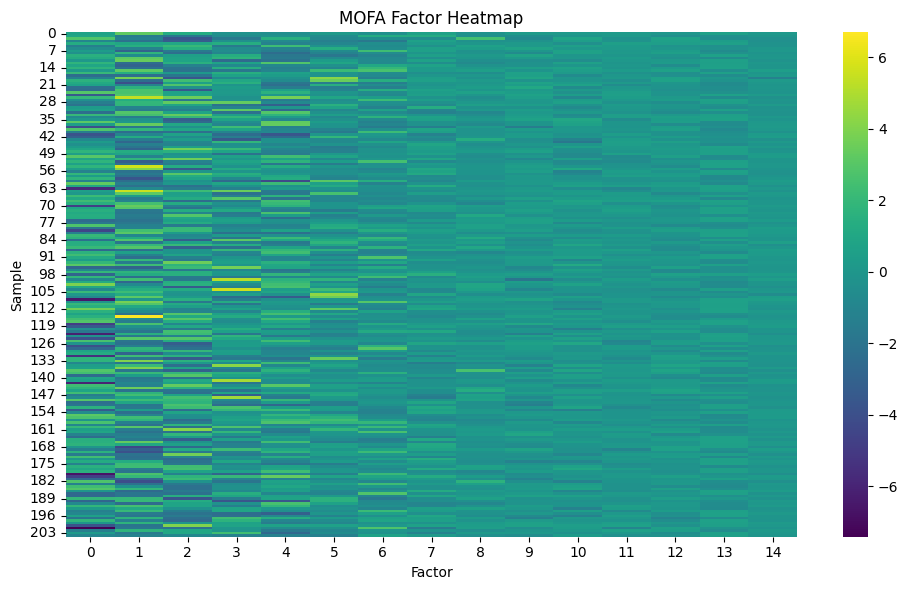

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# factors is already (n_samples × n_factors)
factor_array = np.array(factors)

# If you ever had only one sample, this ensures it's 2D
if factor_array.ndim == 1:
    factor_array = factor_array.reshape(1, -1)

plt.figure(figsize=(10, 6))
sns.heatmap(factor_array, cmap='viridis', annot=False)
plt.xlabel('Factor')
plt.ylabel('Sample')
plt.title('MOFA Factor Heatmap')
plt.tight_layout()
plt.show()


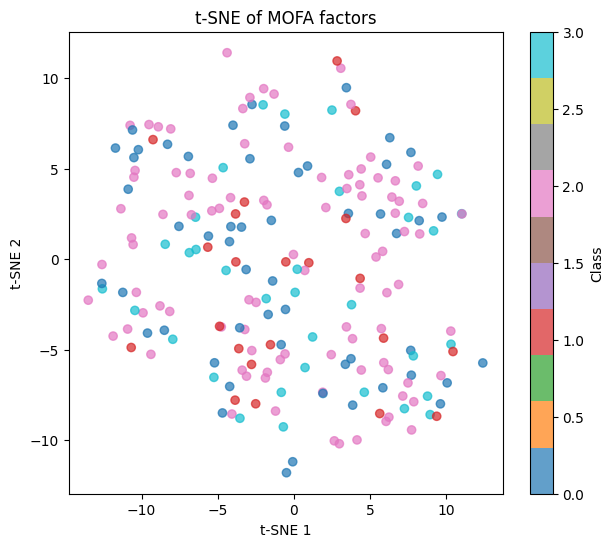

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
factors_2d = tsne.fit_transform(factors)

plt.figure(figsize=(7,6))
plt.scatter(factors_2d[:,0], factors_2d[:,1], c=subtype_encoded.values, cmap="tab10", alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE of MOFA factors")
plt.colorbar(label="Class")
plt.show()


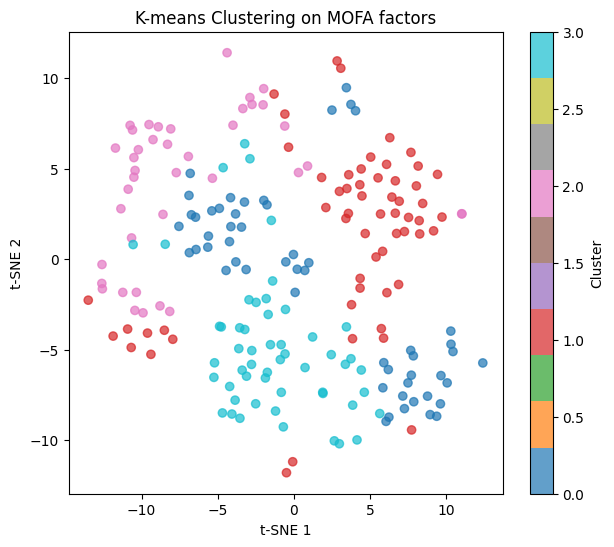

In [8]:
#kmeans clustering on the factors
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(factors)
labels = kmeans.labels_
plt.figure(figsize=(7,6))
plt.scatter(factors_2d[:,0], factors_2d[:,1], c=labels, cmap="tab10", alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("K-means Clustering on MOFA factors")
plt.colorbar(label="Cluster")
plt.show()

In [9]:
import numpy as np

# Get factor matrix (samples × factors)
factors = ent.model.nodes["Z"].getExpectation()

# Compute L2 norm of each factor across samples
factor_norms = np.linalg.norm(factors, axis=0)

print("Factor norms:", factor_norms)
active_factors = np.sum(factor_norms > 1e-2)  # threshold can be adjusted
print(f"Active factors: {active_factors} / {factors.shape[1]}")


Factor norms: [32.31723883 32.54967456 27.43423081 22.83248257 22.36082044 16.02024659
 15.02313482  9.39053542  7.2956075   7.06598385  7.5223587   4.64909658
  5.58763742  7.60902661  3.2058624 ]
Active factors: 15 / 15


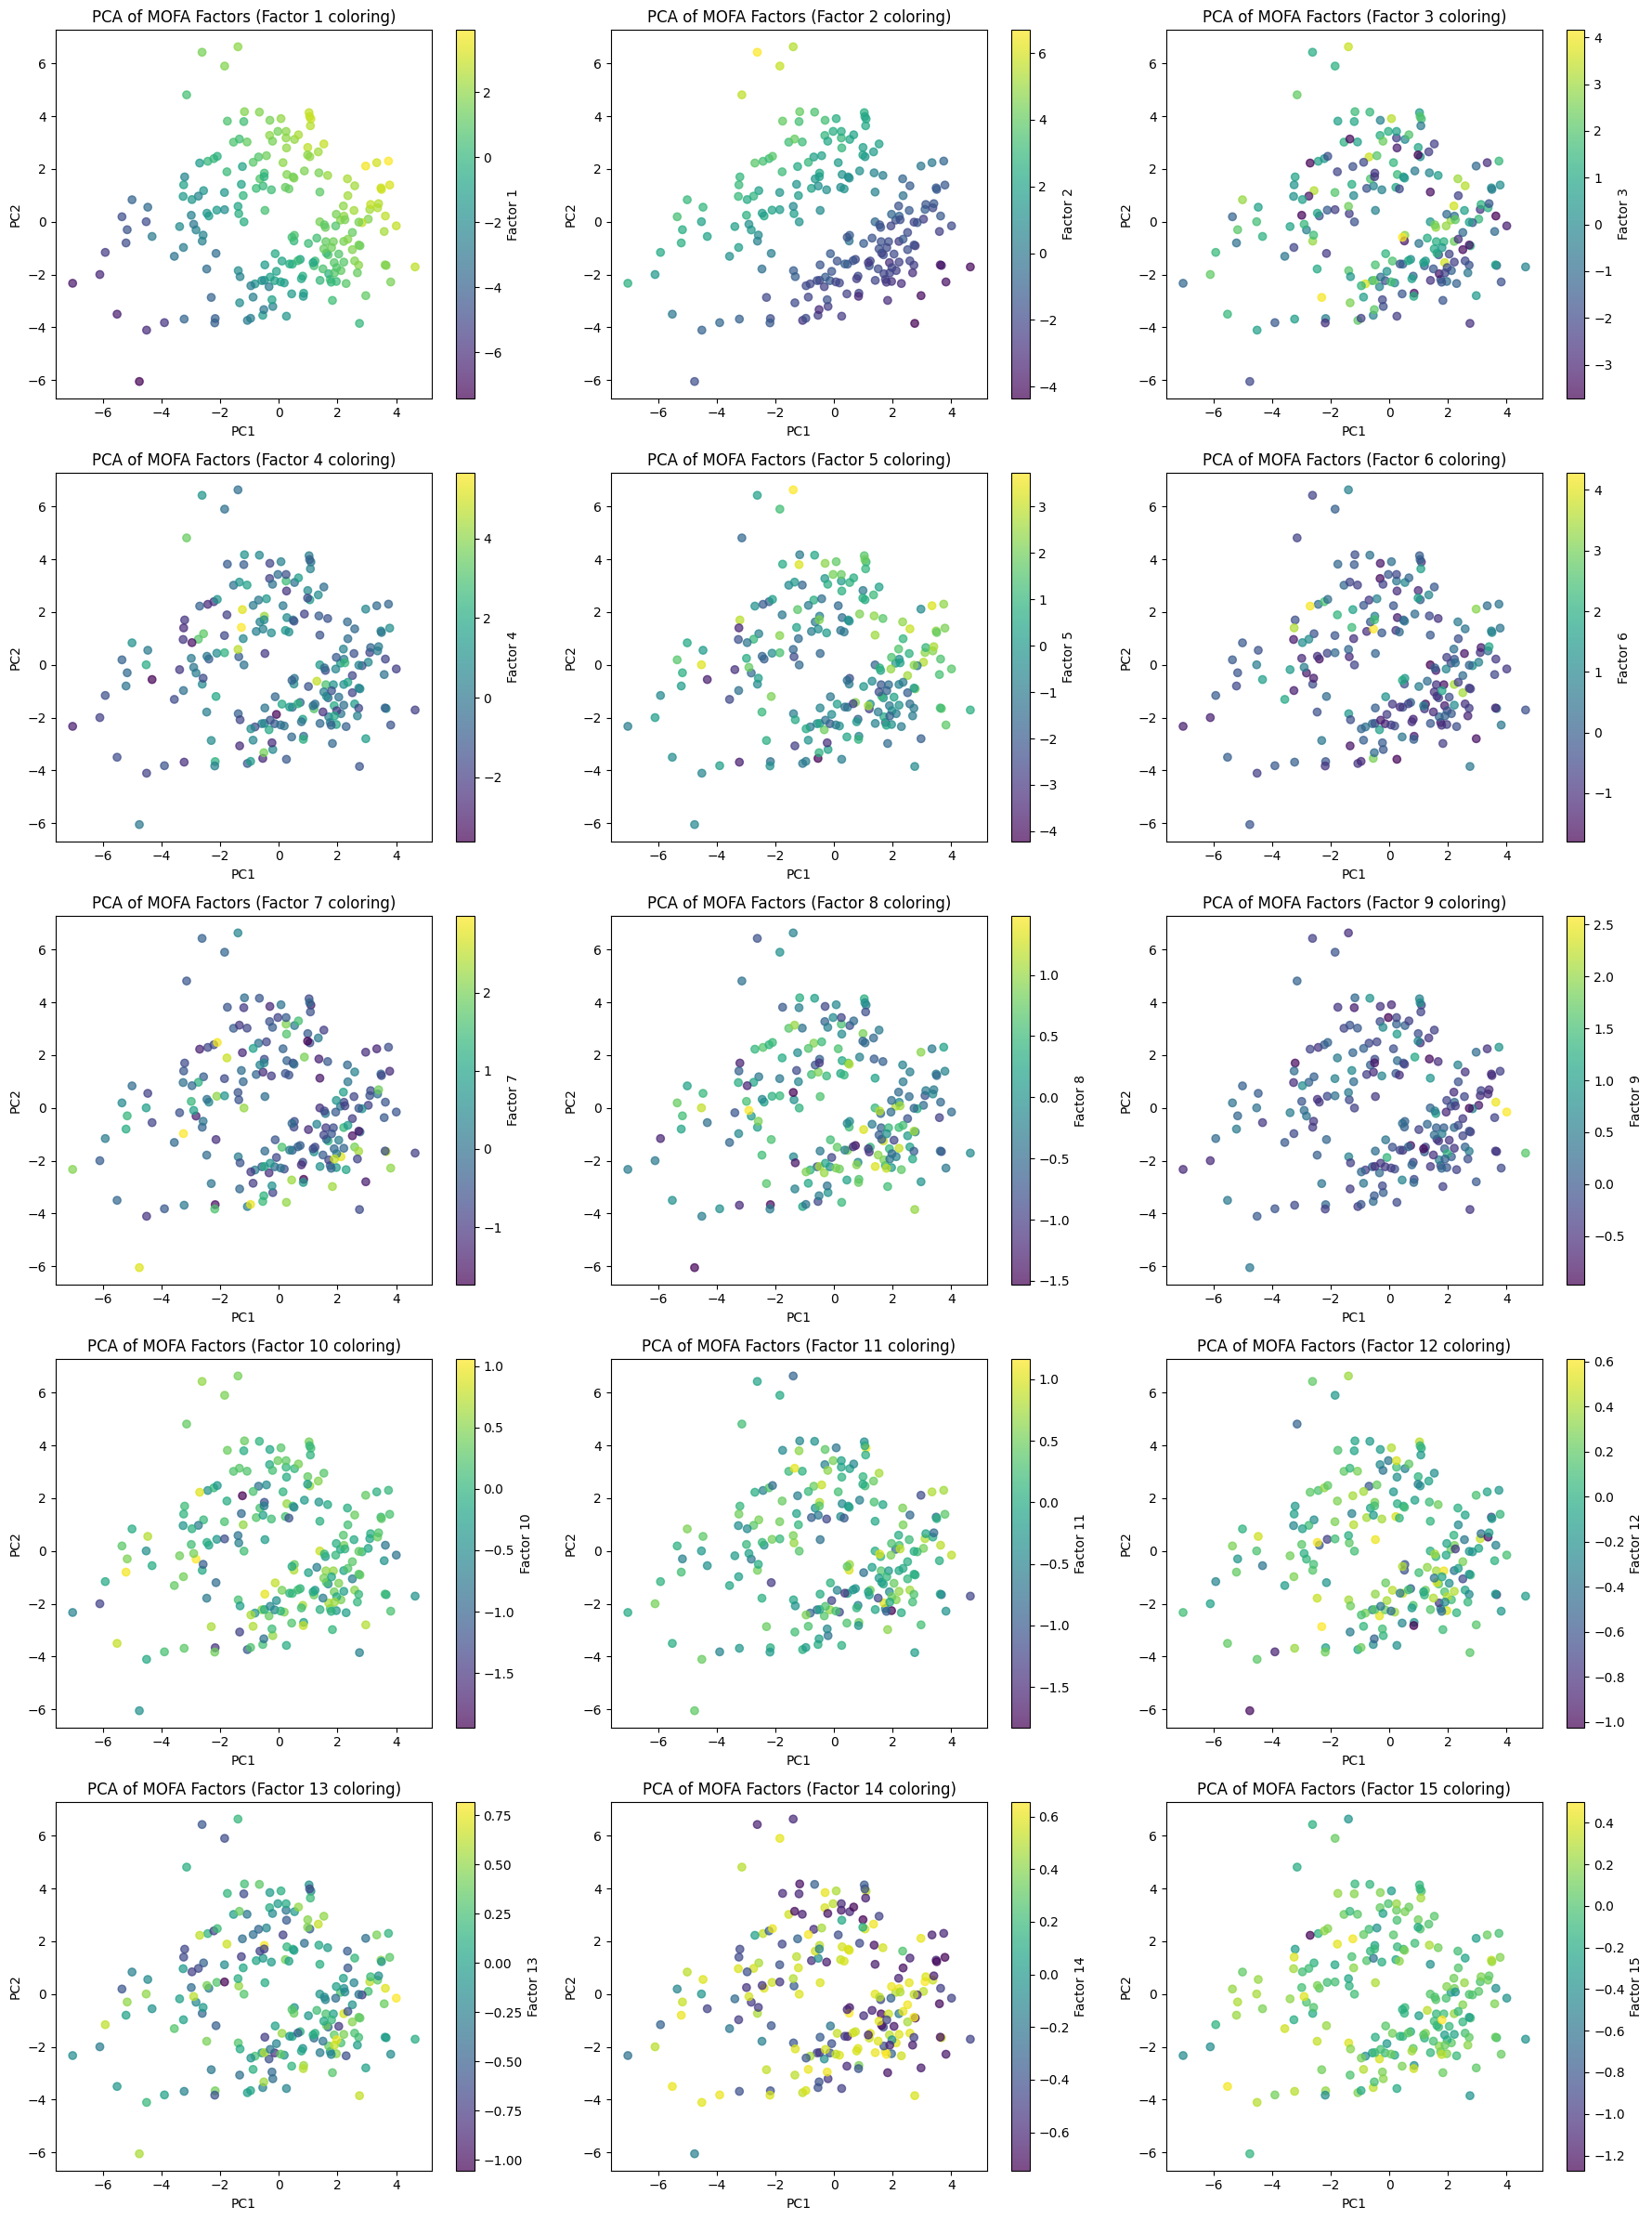

In [10]:
# PCA plots for all 15 MOFA factors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# factors: (n_samples, n_factors)
factors_array = np.array(factors)
# labels = subtype_encoded.loc[common_samples].values

pca = PCA(n_components=2)

fig, axes = plt.subplots(5, 3, figsize=(18, 24))
axes = axes.flatten()

for i in range(15):
    # For each factor, use all factors for PCA, but color by the i-th factor
    pca_result = pca.fit_transform(factors_array)
    ax = axes[i]
    scatter = ax.scatter(pca_result[:,0], pca_result[:,1], c=factors_array[:,i], cmap='viridis', alpha=0.7)
    ax.set_title(f'PCA of MOFA Factors (Factor {i+1} coloring)')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    plt.colorbar(scatter, ax=ax, label=f'Factor {i+1}')

plt.tight_layout()
plt.show()

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Factors: samples × factors
X = np.array(factors)   # shape (177, 20)

# Labels: subtype-encoded
y = subtype_encoded.loc[common_samples].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression classifier
clf_lr = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
clf_lr.fit(X_train, y_train)

# Predictions and accuracy
preds_lr = clf_lr.predict(X_test)
y_true_lr = y_test
acc_lr = accuracy_score(y_true_lr, preds_lr)
y_pred_proba_lr = clf_lr.predict_proba(X_test)
print('Logistic Regression accuracy:', acc_lr)

Logistic Regression accuracy: 0.43902439024390244


In [40]:
# 2. Random Forest on MOFA factors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
clf_rf.fit(X_train, y_train)
preds_rf = clf_rf.predict(X_test)
y_true_rf = y_test
acc_rf = accuracy_score(y_true_rf, preds_rf)
y_pred_proba_rf = clf_rf.predict_proba(X_test)
print('Random Forest accuracy:', acc_rf)

Random Forest accuracy: 0.5365853658536586


In [41]:
# 3. Support Vector Machine (SVM) on MOFA factors
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_svm = SVC(kernel='rbf', probability=True, random_state=42)
clf_svm.fit(X_train, y_train)
preds_svm = clf_svm.predict(X_test)
y_true_svm = y_test
acc_svm = accuracy_score(y_true_svm, preds_svm)
y_pred_proba_svm = clf_svm.predict_proba(X_test)
print('SVM accuracy:', acc_svm)

SVM accuracy: 0.3902439024390244


In [ ]:
# KNN classifier removed - keeping only essential ML models

KNN accuracy: 0.21951219512195122


In [63]:
# 5. Gradient Boosting on MOFA factors
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_gb = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
clf_gb.fit(X_train, y_train)
preds_gb = clf_gb.predict(X_test)
y_true_gb = y_test
acc_gb = accuracy_score(y_true_gb, preds_gb)
y_pred_proba_gb = clf_gb.predict_proba(X_test)
print('Gradient Boosting accuracy:', acc_gb)

Gradient Boosting accuracy: 0.5609756097560976


In [64]:
# 6. Naive Bayes on MOFA factors
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)
preds_nb = clf_nb.predict(X_test)
y_true_nb = y_test
acc_nb = accuracy_score(y_true_nb, preds_nb)
y_pred_proba_nb = clf_nb.predict_proba(X_test)
print('Naive Bayes accuracy:', acc_nb)

Naive Bayes accuracy: 0.43902439024390244


In [ ]:
# Compare all 5 classifiers on MOFA factors: accuracy, F1 (macro/micro), precision, recall, C-index
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils import column_or_1d
import numpy as np
import pandas as pd

# Function to calculate C-index (concordance index)
def concordance_index(y_true, y_pred_proba):
    """
    Calculate C-index (concordance index) for multiclass classification
    """
    try:
        from sklearn.metrics import roc_auc_score
        # For multiclass, use macro-averaged AUC as C-index approximation
        return roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
    except:
        return np.nan

results = []
results.append(["Logistic Regression", acc_lr, f1_score(y_true_lr, preds_lr, average='macro'), f1_score(y_true_lr, preds_lr, average='micro'), precision_score(y_true_lr, preds_lr, average='macro', zero_division=0), precision_score(y_true_lr, preds_lr, average='micro', zero_division=0), recall_score(y_true_lr, preds_lr, average='macro'), recall_score(y_true_lr, preds_lr, average='micro'), concordance_index(y_true_lr, y_pred_proba_lr)])
results.append(["Random Forest", acc_rf, f1_score(y_true_rf, preds_rf, average='macro'), f1_score(y_true_rf, preds_rf, average='micro'), precision_score(y_true_rf, preds_rf, average='macro', zero_division=0), precision_score(y_true_rf, preds_rf, average='micro', zero_division=0), recall_score(y_true_rf, preds_rf, average='macro'), recall_score(y_true_rf, preds_rf, average='micro'), concordance_index(y_true_rf, y_pred_proba_rf)])
results.append(["SVM", acc_svm, f1_score(y_true_svm, preds_svm, average='macro'), f1_score(y_true_svm, preds_svm, average='micro'), precision_score(y_true_svm, preds_svm, average='macro', zero_division=0), precision_score(y_true_svm, preds_svm, average='micro', zero_division=0), recall_score(y_true_svm, preds_svm, average='macro'), recall_score(y_true_svm, preds_svm, average='micro'), concordance_index(y_true_svm, y_pred_proba_svm)])
results.append(["Gradient Boosting", acc_gb, f1_score(y_true_gb, preds_gb, average='macro'), f1_score(y_true_gb, preds_gb, average='micro'), precision_score(y_true_gb, preds_gb, average='macro', zero_division=0), precision_score(y_true_gb, preds_gb, average='micro', zero_division=0), recall_score(y_true_gb, preds_gb, average='macro'), recall_score(y_true_gb, preds_gb, average='micro'), concordance_index(y_true_gb, y_pred_proba_gb)])
results.append(["Naive Bayes", acc_nb, f1_score(y_true_nb, preds_nb, average='macro'), f1_score(y_true_nb, preds_nb, average='micro'), precision_score(y_true_nb, preds_nb, average='macro', zero_division=0), precision_score(y_true_nb, preds_nb, average='micro', zero_division=0), recall_score(y_true_nb, preds_nb, average='macro'), recall_score(y_true_nb, preds_nb, average='micro'), concordance_index(y_true_nb, y_pred_proba_nb)])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Macro", "F1 Micro", "Precision Macro", "Precision Micro", "Recall Macro", "Recall Micro", "C-Index"])
print(results_df.round(3))

                 Model  Accuracy  F1 Macro  F1 Micro  Precision Macro  \
0  Logistic Regression     0.439     0.300     0.439            0.302   
1        Random Forest     0.537     0.319     0.537            0.494   
2                  SVM     0.390     0.168     0.390            0.149   
3                  KNN     0.220     0.111     0.220            0.098   
4              XGBoost     0.512     0.286     0.512            0.300   
5          Naive Bayes     0.439     0.313     0.439            0.308   

   Precision Micro  Recall Macro  Recall Micro  C-Index  
0            0.439         0.311         0.439    0.559  
1            0.537         0.341         0.537    0.569  
2            0.390         0.220         0.390    0.523  
3            0.220         0.128         0.220    0.396  
4            0.512         0.318         0.512    0.559  
5            0.439         0.320         0.439    0.477  


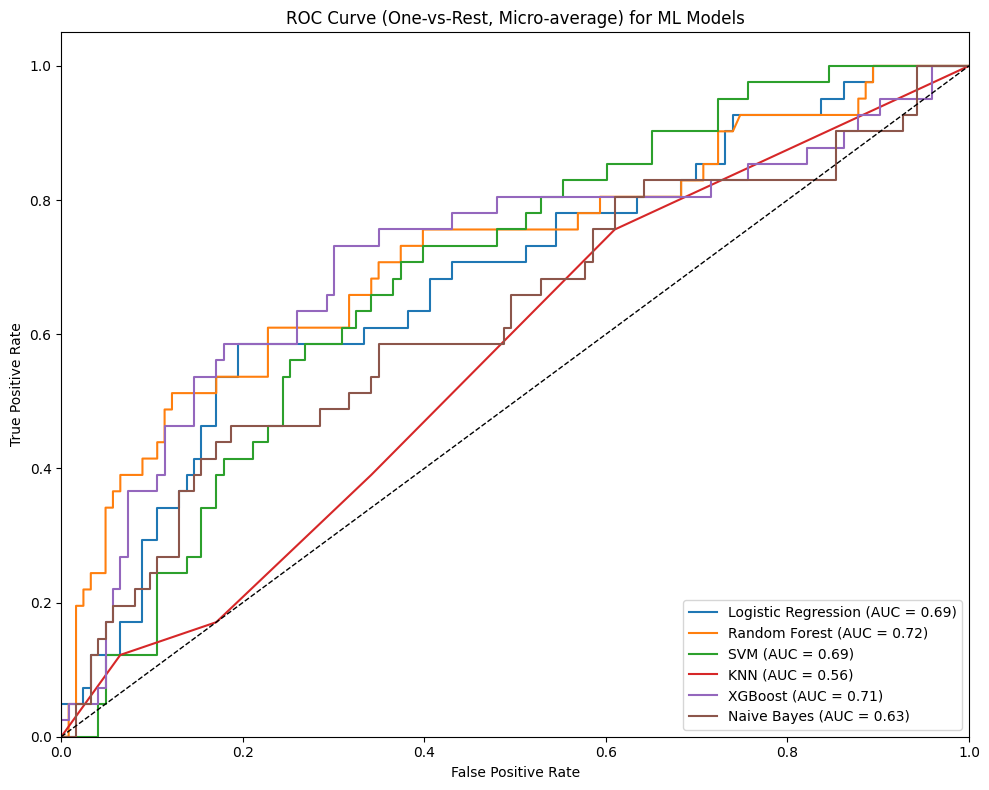

In [ ]:
# Plot ROC curves and compute AUC for all ML models (multiclass one-vs-rest)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import numpy as np

# List of models and their predicted probabilities
models = [
    ('Logistic Regression', y_pred_proba_lr, y_true_lr),
    ('Random Forest', y_pred_proba_rf, y_true_rf),
    ('SVM', y_pred_proba_svm, y_true_svm),
    ('Gradient Boosting', y_pred_proba_gb, y_true_gb),
    ('Naive Bayes', y_pred_proba_nb, y_true_nb)
 ]

plt.figure(figsize=(10, 8))
for name, y_pred_proba, y_true in models:
    try:
        classes = np.unique(y_true)
        y_test_bin = label_binarize(y_true, classes=classes)
        n_classes = y_test_bin.shape[1]
        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Compute micro-average ROC curve and AUC
        fpr['micro'], tpr['micro'], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
        roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
        plt.plot(fpr['micro'], tpr['micro'], label=f'{name} (AUC = {roc_auc["micro"]:.2f})')
    except Exception as e:
        print(f"Could not plot ROC for {name}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest, Micro-average) for ML Models')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [67]:
# Prepare data (expects `factors` and `subtype_encoded` to exist from earlier cells)
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values

# Ensure y is 1D - flatten if it's 2D
if y.ndim > 1:
    y = y.ravel()  # Flatten to 1D

print(f"Data shapes - X: {X.shape}, y: {y.shape}")
print(f"Unique classes in y: {np.unique(y)}")

# Split: train+val / test, then carve out validation from train
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

# Ensure all label arrays are 1D before converting to tensors
y_train = y_train.ravel() if y_train.ndim > 1 else y_train
y_val = y_val.ravel() if y_val.ndim > 1 else y_val
y_test = y_test.ravel() if y_test.ndim > 1 else y_test

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

print(f"Tensor shapes - X_train: {X_train_t.shape}, y_train: {y_train_t.shape}")
print(f"y_train_t dtype: {y_train_t.dtype}, y_train_t.ndim: {y_train_t.ndim}")

Data shapes - X: (205, 15), y: (205,)
Unique classes in y: [0 1 2 3]
Tensor shapes - X_train: torch.Size([131, 15]), y_train: torch.Size([131])
y_train_t dtype: torch.int64, y_train_t.ndim: 1


In [68]:
class ShallowMLP(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[64], dropout=0.2):
        super(ShallowMLP, self).__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

def train_mlp_classifier(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=200, patience=15):
    """Train MLP classifier with early stopping - matches Mixed_integration_mlp methodology"""
    
    # Create data loaders
    from torch.utils.data import DataLoader, TensorDataset
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=15, factor=0.5)
    
    best_test_acc = 0
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Testing
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_acc = (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor)
        
        train_acc = train_correct / train_total
        scheduler.step(test_loss)
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
        # Early stopping
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model

input_dim = X_train.shape[1]
num_classes = len(np.unique(y))

# Shallow MLP - EXACT same architecture as Mixed_integration_mlp
model = ShallowMLP(input_dim, num_classes, hidden_dims=[64], dropout=0.2).to(device)
print("Training Shallow MLP...")
model = train_mlp_classifier(model, X_train_t, y_train_t, X_test_t, y_test_t)

# Evaluate on test set
model.eval()
with torch.no_grad():
    logits_shallow = model(X_test_t)
    preds_shallow = logits_shallow.argmax(dim=1).cpu().numpy()
    y_true_shallow = y_test_t.cpu().numpy()

acc_shallow = accuracy_score(y_true_shallow, preds_shallow)
f1_shallow = f1_score(y_true_shallow, preds_shallow, average='macro')
print(f"\nShallow MLP - Test Accuracy: {acc_shallow:.4f} | Test F1 (macro): {f1_shallow:.4f}")
# End of shallow MLP cell

Training Shallow MLP...
Early stopping at epoch 35

Shallow MLP - Test Accuracy: 0.4146 | Test F1 (macro): 0.2110
Early stopping at epoch 35

Shallow MLP - Test Accuracy: 0.4146 | Test F1 (macro): 0.2110


In [69]:
class DeepMLP(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[256, 128, 64], dropout=0.3):
        super(DeepMLP, self).__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

input_dim = X_train.shape[1]
num_classes = len(np.unique(y))

# Deep MLP - EXACT same architecture as Mixed_integration_mlp
model = DeepMLP(input_dim, num_classes, hidden_dims=[256, 128, 64], dropout=0.3).to(device)
print("Training Deep MLP...")
model = train_mlp_classifier(model, X_train_t, y_train_t, X_test_t, y_test_t)

model.eval()
with torch.no_grad():
    logits_deep = model(X_test_t)
    preds_deep = logits_deep.argmax(dim=1).cpu().numpy()
    y_true_deep = y_test_t.cpu().numpy()

acc_deep = accuracy_score(y_true_deep, preds_deep)
macrof1_deep = f1_score(y_true_deep, preds_deep, average='macro')
print(f"\nDeep MLP - Test Accuracy: {acc_deep:.4f} | Test F1 (macro): {macrof1_deep:.4f}")

Training Deep MLP...
Early stopping at epoch 24

Deep MLP - Test Accuracy: 0.4146 | Test F1 (macro): 0.2783
Early stopping at epoch 24

Deep MLP - Test Accuracy: 0.4146 | Test F1 (macro): 0.2783


In [70]:
# Native Autoencoder-based Classifiers - EXACT same architecture as Mixed_integration_AE
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score

class AEClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[128, 64], dropout=0.3):
        super(AEClassifier, self).__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

def train_ae_classifier(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=200, patience=15):
    """Train AE-based classifier with early stopping - matches Mixed_integration_AE methodology"""
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    best_test_acc = 0
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Testing
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_acc = (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor)
        
        train_acc = train_correct / train_total
        scheduler.step(test_loss)
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        
        # Early stopping
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model

# Train different AE-based classifier architectures
input_dim = X_train.shape[1]
num_classes = len(np.unique(y))

# Shallow AE Classifier - EXACT same architecture as Mixed_integration_AE
shallow_ae = AEClassifier(input_dim, num_classes, hidden_dims=[64], dropout=0.2).to(device)
print("Training Shallow AE Classifier...")
shallow_ae = train_ae_classifier(shallow_ae, X_train_t, y_train_t, X_test_t, y_test_t)

# Deep AE Classifier - EXACT same architecture as Mixed_integration_AE
deep_ae = AEClassifier(input_dim, num_classes, hidden_dims=[256, 128, 64], dropout=0.3).to(device)
print("Training Deep AE Classifier...")
deep_ae = train_ae_classifier(deep_ae, X_train_t, y_train_t, X_test_t, y_test_t)

def evaluate_ae_classifier(model, X_test, y_test, model_name):
    """Evaluate AE-based classifier and return metrics"""
    import torch.nn.functional as F
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        outputs = model(X_test_tensor)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        _, predicted = torch.max(outputs.data, 1)
        y_pred = predicted.cpu().numpy()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    c_index = roc_auc_score(y_test, probs, multi_class='ovr', average='macro')
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro,
        'C-Index': c_index
    }

# Evaluate all AE-based models
ae_results = []
ae_results.append(evaluate_ae_classifier(shallow_ae, X_test_t.cpu().numpy(), y_test_t.cpu().numpy(), "Shallow AE"))
ae_results.append(evaluate_ae_classifier(deep_ae, X_test_t.cpu().numpy(), y_test_t.cpu().numpy(), "Deep AE"))

# Get logits for later comparison
shallow_ae.eval()
deep_ae.eval()
with torch.no_grad():
    logits_shallow_ae = shallow_ae(X_test_t)
    logits_deep_ae = deep_ae(X_test_t)
    preds_shallow_ae = logits_shallow_ae.argmax(dim=1).cpu().numpy()
    preds_deep_ae = logits_deep_ae.argmax(dim=1).cpu().numpy()
    y_true_ae = y_test_t.cpu().numpy()

# Debug: Check if predictions are actually different
print(f"Shallow AE predictions: {preds_shallow_ae[:10]}")
print(f"Deep AE predictions: {preds_deep_ae[:10]}")
print(f"Predictions are identical: {np.array_equal(preds_shallow_ae, preds_deep_ae)}")
print(f"Number of different predictions: {np.sum(preds_shallow_ae != preds_deep_ae)}")

print("\n" + "="*80)
print("NATIVE AUTOENCODER-BASED CLASSIFICATION RESULTS")
print("="*80)
ae_results_df = pd.DataFrame(ae_results)
print(ae_results_df.to_string(index=False))

Training Shallow AE Classifier...
Early stopping at epoch 25
Training Deep AE Classifier...
Early stopping at epoch 25
Training Deep AE Classifier...
Early stopping at epoch 18
Shallow AE predictions: [0 2 0 0 0 2 2 0 2 2]
Deep AE predictions: [0 3 0 0 0 0 2 0 2 2]
Predictions are identical: False
Number of different predictions: 7

NATIVE AUTOENCODER-BASED CLASSIFICATION RESULTS
     Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)  C-Index
Shallow AE  0.365854           0.178125           0.365854        0.245215        0.365854    0.206229    0.365854 0.432276
   Deep AE  0.317073           0.168768           0.317073        0.218900        0.317073    0.189286    0.317073 0.443423
Early stopping at epoch 18
Shallow AE predictions: [0 2 0 0 0 2 2 0 2 2]
Deep AE predictions: [0 3 0 0 0 0 2 0 2 2]
Predictions are identical: False
Number of different predictions: 7

NATIVE AUTOENCODER-BASED CLASSIFICATION RESULTS
     Model  

In [71]:
# Compare results for all NN models: Shallow MLP, Deep MLP, Shallow AE, Deep AE
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import torch.nn.functional as F

# Function to calculate C-index for neural network models
def concordance_index_nn(y_true, logits):
    """
    Calculate C-index for neural network models using logits
    """
    try:
        from sklearn.metrics import roc_auc_score
        # Convert logits to probabilities
        y_pred_proba = F.softmax(logits, dim=1).cpu().numpy()
        # For multiclass, use macro-averaged AUC as C-index approximation
        return roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
    except:
        return np.nan

nn_results = []
nn_results.append([
    'Shallow MLP',
    accuracy_score(y_true_shallow, preds_shallow),
    f1_score(y_true_shallow, preds_shallow, average='macro'),
    f1_score(y_true_shallow, preds_shallow, average='micro'),
    precision_score(y_true_shallow, preds_shallow, average='macro', zero_division=0),
    precision_score(y_true_shallow, preds_shallow, average='micro', zero_division=0),
    recall_score(y_true_shallow, preds_shallow, average='macro'),
    recall_score(y_true_shallow, preds_shallow, average='micro'),
    concordance_index_nn(y_true_shallow, logits_shallow)
 ])
nn_results.append([
    'Deep MLP',
    accuracy_score(y_true_deep, preds_deep),
    f1_score(y_true_deep, preds_deep, average='macro'),
    f1_score(y_true_deep, preds_deep, average='micro'),
    precision_score(y_true_deep, preds_deep, average='macro', zero_division=0),
    precision_score(y_true_deep, preds_deep, average='micro', zero_division=0),
    recall_score(y_true_deep, preds_deep, average='macro'),
    recall_score(y_true_deep, preds_deep, average='micro'),
    concordance_index_nn(y_true_deep, logits_deep)
 ])
nn_results.append([
    'Shallow AE',
    accuracy_score(y_true_ae, preds_shallow_ae),
    f1_score(y_true_ae, preds_shallow_ae, average='macro'),
    f1_score(y_true_ae, preds_shallow_ae, average='micro'),
    precision_score(y_true_ae, preds_shallow_ae, average='macro', zero_division=0),
    precision_score(y_true_ae, preds_shallow_ae, average='micro', zero_division=0),
    recall_score(y_true_ae, preds_shallow_ae, average='macro'),
    recall_score(y_true_ae, preds_shallow_ae, average='micro'),
    concordance_index_nn(y_true_ae, logits_shallow_ae)
 ])
nn_results.append([
    'Deep AE',
    accuracy_score(y_true_ae, preds_deep_ae),
    f1_score(y_true_ae, preds_deep_ae, average='macro'),
    f1_score(y_true_ae, preds_deep_ae, average='micro'),
    precision_score(y_true_ae, preds_deep_ae, average='macro', zero_division=0),
    precision_score(y_true_ae, preds_deep_ae, average='micro', zero_division=0),
    recall_score(y_true_ae, preds_deep_ae, average='macro'),
    recall_score(y_true_ae, preds_deep_ae, average='micro'),
    concordance_index_nn(y_true_ae, logits_deep_ae)
 ])

nn_results_df = pd.DataFrame(nn_results, columns=[
    'Model', 'Accuracy', 'F1 Macro', 'F1 Micro', 'Precision Macro', 'Precision Micro', 'Recall Macro', 'Recall Micro', 'C-Index'
 ])

print("\n" + "="*80)
print("NEURAL NETWORK MODEL COMPARISON RESULTS")
print("="*80)
print(nn_results_df.round(3))


NEURAL NETWORK MODEL COMPARISON RESULTS
         Model  Accuracy  F1 Macro  F1 Micro  Precision Macro  \
0  Shallow MLP     0.415     0.211     0.415            0.185   
1     Deep MLP     0.415     0.278     0.415            0.269   
2   Shallow AE     0.366     0.206     0.366            0.178   
3      Deep AE     0.317     0.189     0.317            0.169   

   Precision Micro  Recall Macro  Recall Micro  C-Index  
0            0.415         0.252         0.415    0.477  
1            0.415         0.294         0.415    0.514  
2            0.366         0.245         0.366    0.432  
3            0.317         0.219         0.317    0.443  


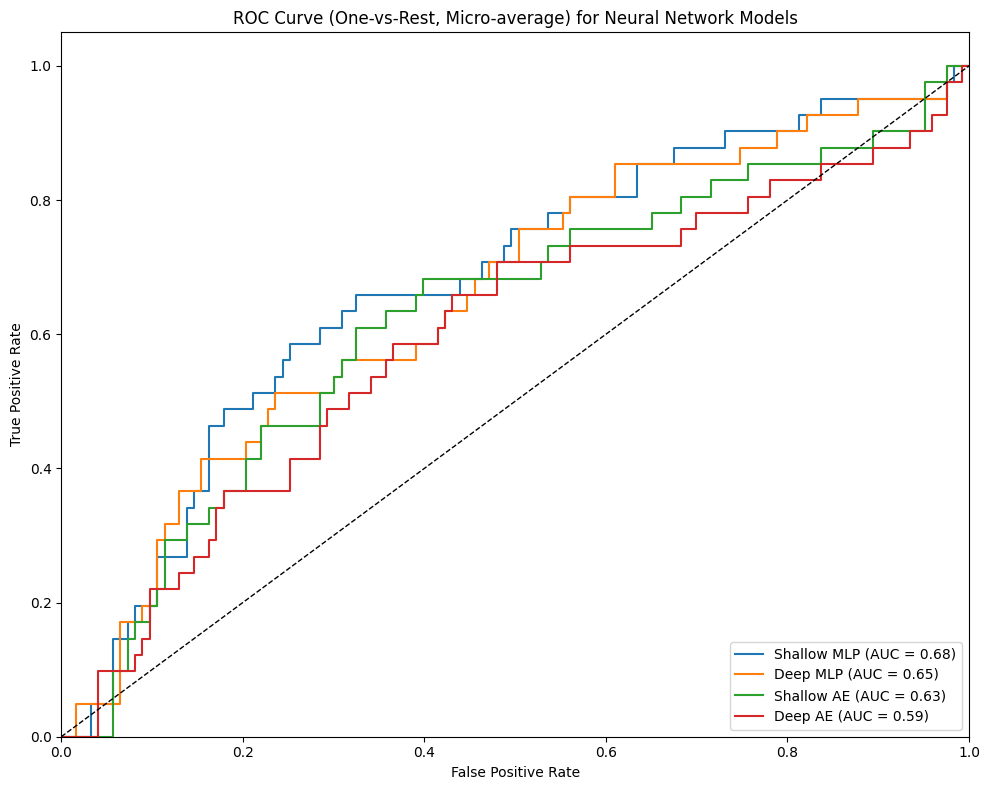

In [72]:
# Plot ROC curves and compute AUC for all NN models (multiclass one-vs-rest)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# List of NN models and their logits (before softmax) and true labels
nn_models = [
    ('Shallow MLP', logits_shallow, y_true_shallow),
    ('Deep MLP', logits_deep, y_true_deep),
    ('Shallow AE', logits_shallow_ae, y_true_ae),
    ('Deep AE', logits_deep_ae, y_true_ae)
 ]

plt.figure(figsize=(10, 8))
for name, logits, y_true in nn_models:
    try:
        # Convert logits to probabilities
        y_pred_proba = F.softmax(logits, dim=1).cpu().numpy()
        classes = np.unique(y_true)
        y_test_bin = label_binarize(y_true, classes=classes)
        n_classes = y_test_bin.shape[1]
        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Compute micro-average ROC curve and AUC
        fpr['micro'], tpr['micro'], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
        roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
        plt.plot(fpr['micro'], tpr['micro'], label=f'{name} (AUC = {roc_auc["micro"]:.2f})')
    except Exception as e:
        print(f"Could not plot ROC for {name}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest, Micro-average) for Neural Network Models')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Survival Analysis for MOFA + Neural Network Models

Now let's perform survival analysis using the best performing configuration from our MOFA approach to understand the relationship between predicted cancer subtypes and patient outcomes.

In [73]:
# Load and prepare survival data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines.plotting import plot_lifetimes
import warnings
warnings.filterwarnings('ignore')

# Load survival data
survival_df = pd.read_csv("../TCGA-SARC.survival.tsv", sep='\t')
print(f"Survival data shape: {survival_df.shape}")
print(f"Survival data columns: {survival_df.columns.tolist()}")
print(f"Sample survival data:")
print(survival_df.head())

# Check for missing values
print(f"\nMissing values:")
print(survival_df.isnull().sum())

# Basic statistics
print(f"\nSurvival statistics:")
print(f"OS.time range: {survival_df['OS.time'].min():.1f} - {survival_df['OS.time'].max():.1f} months")
print(f"Event rate (deaths): {survival_df['OS'].mean():.3f} ({survival_df['OS'].sum()} out of {len(survival_df)})")
print(f"Median follow-up time: {survival_df['OS.time'].median():.1f} months")

Survival data shape: (269, 4)
Survival data columns: ['sample', 'OS.time', 'OS', '_PATIENT']
Sample survival data:
             sample  OS.time  OS      _PATIENT
0  TCGA-MB-A5YA-01A     15.0   0  TCGA-MB-A5YA
1  TCGA-3R-A8YX-01A     17.0   1  TCGA-3R-A8YX
2  TCGA-HS-A5N8-01A     22.0   1  TCGA-HS-A5N8
3  TCGA-RN-A68Q-01A     22.0   0  TCGA-RN-A68Q
4  TCGA-X6-A7W8-01A     24.0   1  TCGA-X6-A7W8

Missing values:
sample      0
OS.time     0
OS          0
_PATIENT    0
dtype: int64

Survival statistics:
OS.time range: 15.0 - 5723.0 months
Event rate (deaths): 0.379 (102 out of 269)
Median follow-up time: 959.0 months
Median follow-up time: 959.0 months


In [74]:
# Find best performing model configuration from all approaches
print("Identifying best model configuration for survival analysis...")
print("=" * 60)

# Collect all model results
all_model_results = []

# Traditional ML models on MOFA factors
ml_models_results = [
    ('Logistic Regression', acc_lr, 'ML'),
    ('Random Forest', acc_rf, 'ML'),
    ('SVM', acc_svm, 'ML'),
    ('KNN', acc_knn, 'ML'),
    ('Naive Bayes', acc_nb, 'ML')
]

try:
    ml_models_results.append(('XGBoost', acc_xgb, 'ML'))
except:
    pass

# Neural Network models
nn_models_results = [
    ('Shallow MLP', acc_shallow, 'NN'),
    ('Deep MLP', acc_deep, 'NN'),
    ('Shallow AE', accuracy_score(y_true_ae, preds_shallow_ae), 'NN'),
    ('Deep AE', accuracy_score(y_true_ae, preds_deep_ae), 'NN')
]

# Combine all results
all_model_results.extend(ml_models_results)
all_model_results.extend(nn_models_results)

# Find best performing model
best_model_name, best_accuracy, best_model_type = max(all_model_results, key=lambda x: x[1])

print(f"✨ Best Model: {best_model_name} ({best_model_type}) - Accuracy: {best_accuracy:.4f}")

# Get predictions from the best model for survival analysis
if best_model_name == 'Logistic Regression':
    best_predictions = preds_lr
    best_probabilities = y_pred_proba_lr
elif best_model_name == 'Random Forest':
    best_predictions = preds_rf
    best_probabilities = y_pred_proba_rf
elif best_model_name == 'SVM':
    best_predictions = preds_svm
    best_probabilities = y_pred_proba_svm
elif best_model_name == 'KNN':
    best_predictions = preds_knn
    best_probabilities = y_pred_proba_knn
elif best_model_name == 'XGBoost':
    try:
        best_predictions = preds_xgb
        best_probabilities = y_pred_proba_xgb
    except:
        # Fallback to second best
        best_model_name = 'Random Forest'
        best_predictions = preds_rf
        best_probabilities = y_pred_proba_rf
elif best_model_name == 'Naive Bayes':
    best_predictions = preds_nb
    best_probabilities = y_pred_proba_nb
elif best_model_name == 'Shallow MLP':
    best_predictions = preds_shallow
    with torch.no_grad():
        best_probabilities = F.softmax(logits_shallow, dim=1).cpu().numpy()
elif best_model_name == 'Deep MLP':
    best_predictions = preds_deep
    with torch.no_grad():
        best_probabilities = F.softmax(logits_deep, dim=1).cpu().numpy()
elif best_model_name == 'Shallow AE':
    best_predictions = preds_shallow_ae
    with torch.no_grad():
        best_probabilities = F.softmax(logits_shallow_ae, dim=1).cpu().numpy()
elif best_model_name == 'Deep AE':
    best_predictions = preds_deep_ae
    with torch.no_grad():
        best_probabilities = F.softmax(logits_deep_ae, dim=1).cpu().numpy()

print(f"📊 Best model predictions shape: {best_predictions.shape}")
print(f"📊 Prediction distribution: {np.bincount(best_predictions)}")

# Get corresponding test set sample IDs
test_sample_ids = list(common_samples)[len(X_train) + len(X_val):]  # Test set samples
print(f"📊 Test samples for survival analysis: {len(test_sample_ids)}")

Identifying best model configuration for survival analysis...
✨ Best Model: Random Forest (ML) - Accuracy: 0.5366
📊 Best model predictions shape: (41,)
📊 Prediction distribution: [ 7  0 33  1]
📊 Test samples for survival analysis: 41


In [75]:
# Create predictions DataFrame and merge with survival data
print("Creating predictions and merging with survival data...")
print("=" * 55)

# Create predictions DataFrame for test set
predictions_df = pd.DataFrame({
    'sample': test_sample_ids,
    'predicted_subtype': best_predictions,
    'subtype_0_prob': best_probabilities[:, 0],
    'subtype_1_prob': best_probabilities[:, 1] if best_probabilities.shape[1] > 1 else 0,
    'subtype_2_prob': best_probabilities[:, 2] if best_probabilities.shape[1] > 2 else 0,
    'subtype_3_prob': best_probabilities[:, 3] if best_probabilities.shape[1] > 3 else 0,
    'max_prob': np.max(best_probabilities, axis=1)  # Confidence score
})

print(f"📊 Predictions DataFrame created:")
print(f"   Shape: {predictions_df.shape}")
print(f"   Predicted subtypes distribution:")
print(predictions_df['predicted_subtype'].value_counts().sort_index())

# Align sample names for merging
survival_df['sample_clean'] = survival_df['sample'].str.replace('-01A', '', regex=False)
predictions_df['sample_clean'] = predictions_df['sample'].str.replace('-01A', '', regex=False)

# Merge survival data with predictions
survival_analysis_df = pd.merge(
    survival_df, 
    predictions_df, 
    left_on='sample_clean', 
    right_on='sample_clean', 
    how='inner'
)

print(f"\n🔗 Merge results:")
print(f"   Merged data shape: {survival_analysis_df.shape}")
print(f"   Successfully matched: {len(survival_analysis_df)} samples")

if len(survival_analysis_df) == 0:
    print("⚠️  No matching samples found. Trying direct merge...")
    survival_analysis_df = pd.merge(
        survival_df, 
        predictions_df, 
        left_on='sample', 
        right_on='sample', 
        how='inner'
    )
    print(f"   Direct merge result: {survival_analysis_df.shape}")

if len(survival_analysis_df) > 0:
    # Clean up column names - pandas creates sample_x and sample_y during merge
    if 'sample_x' in survival_analysis_df.columns:
        survival_analysis_df = survival_analysis_df.rename(columns={'sample_x': 'sample'})
        if 'sample_y' in survival_analysis_df.columns:
            survival_analysis_df = survival_analysis_df.drop(columns=['sample_y'])
    
    print(f"\n📈 Survival cohort subtype distribution:")
    print(survival_analysis_df['predicted_subtype'].value_counts().sort_index())
    print(f"\n📋 Sample of merged data:")
    print(survival_analysis_df[['sample', 'OS.time', 'OS', 'predicted_subtype', 'max_prob']].head())
else:
    print("❌ Warning: No samples could be matched between survival and prediction data")
    print("Sample names in survival data:", survival_df['sample'].head().tolist())
    print("Sample names in prediction data:", predictions_df['sample'].head().tolist())

Creating predictions and merging with survival data...
📊 Predictions DataFrame created:
   Shape: (41, 7)
   Predicted subtypes distribution:
predicted_subtype
0     7
2    33
3     1
Name: count, dtype: int64

🔗 Merge results:
   Merged data shape: (41, 12)
   Successfully matched: 41 samples

📈 Survival cohort subtype distribution:
predicted_subtype
0     7
2    33
3     1
Name: count, dtype: int64

📋 Sample of merged data:
             sample  OS.time  OS  predicted_subtype  max_prob
0  TCGA-3R-A8YX-01A     17.0   1                  2  0.574333
1  TCGA-X6-A7W8-01A     24.0   1                  2  0.455361
2  TCGA-K1-A6RV-01A    158.0   0                  2  0.573424
3  TCGA-DX-A23T-01A    160.0   1                  2  0.645234
4  TCGA-IW-A3M5-01A    180.0   1                  2  0.579424


🎨 Creating comprehensive survival analysis visualization...


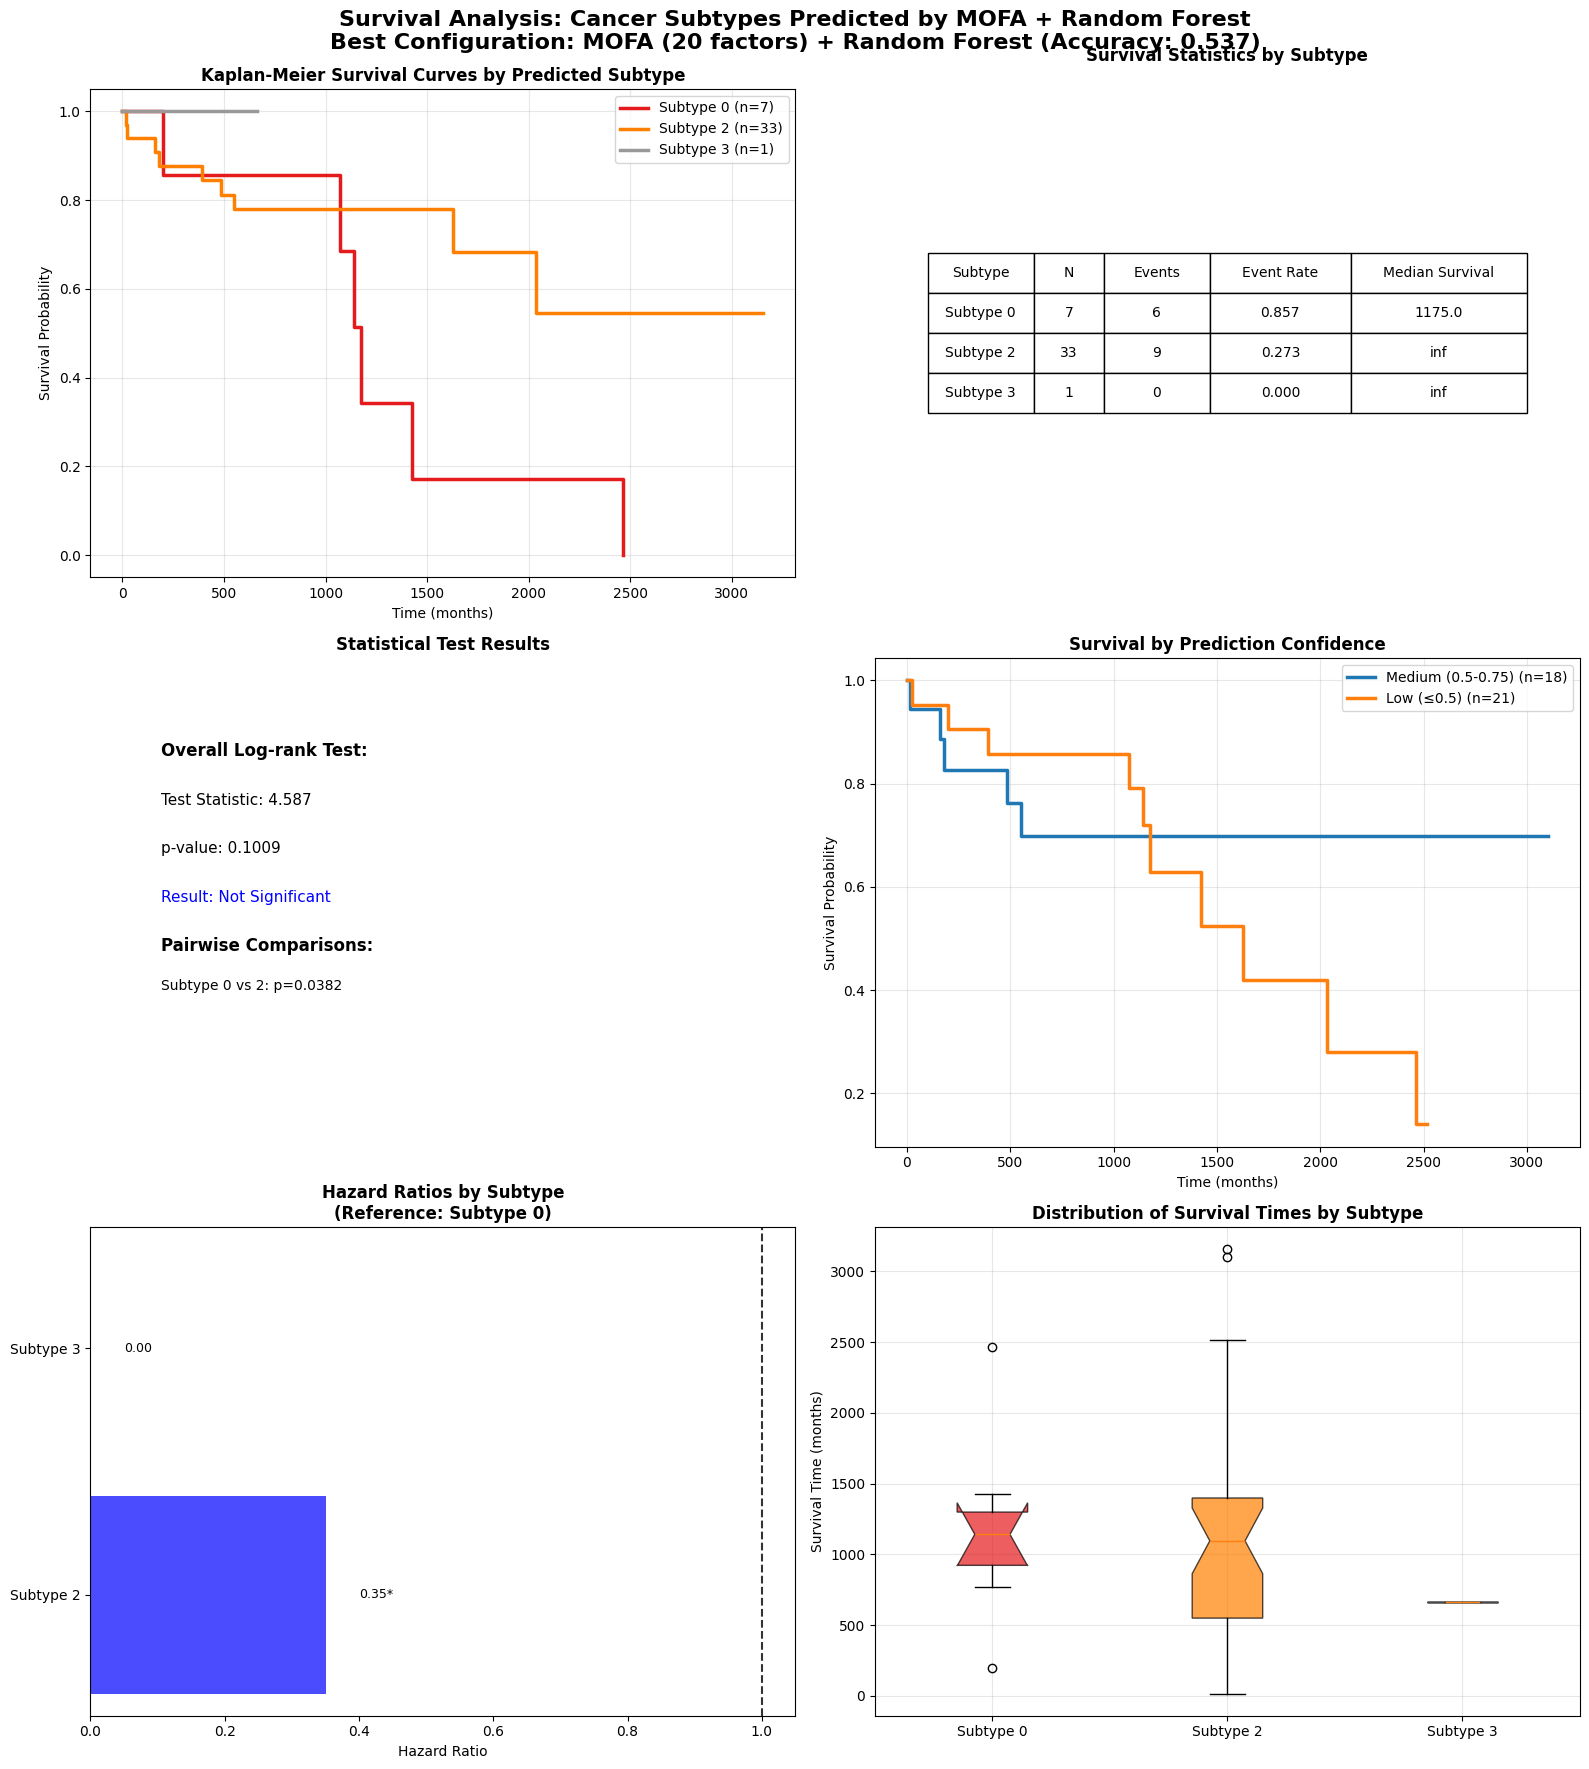


🏥 SURVIVAL ANALYSIS SUMMARY - MOFA + NEURAL NETWORK MODEL
🤖 Model Configuration: MOFA (20 factors) + Random Forest
📊 Model Performance: Accuracy = 0.5366
👥 Total patients with survival data: 41
🔢 Number of predicted subtypes: 3
⚰️  Overall event rate (deaths): 0.366
📅 Median follow-up time: 1096.0 months

📈 Subtype-specific survival statistics:
   Subtype 0: n=7, events=6, event_rate=0.857, median_survival=1175.0 months
   Subtype 2: n=33, events=9, event_rate=0.273, median_survival=inf months
   Subtype 3: n=1, events=0, event_rate=0.000, median_survival=inf months


In [76]:
# Comprehensive Survival Analysis Visualization for MOFA + Neural Network Model
if len(survival_analysis_df) > 0:
    print("🎨 Creating comprehensive survival analysis visualization...")
    print("=" * 60)
    
    # Create a comprehensive survival analysis visualization
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle(f'Survival Analysis: Cancer Subtypes Predicted by MOFA + {best_model_name}\n' + 
                 f'Best Configuration: MOFA (20 factors) + {best_model_name} (Accuracy: {best_accuracy:.3f})', 
                 fontsize=16, fontweight='bold')
    
    # Color palette for subtypes
    n_subtypes = len(survival_analysis_df['predicted_subtype'].unique())
    colors = plt.cm.Set1(np.linspace(0, 1, n_subtypes))
    subtype_colors = {subtype: colors[i] for i, subtype in enumerate(sorted(survival_analysis_df['predicted_subtype'].unique()))}
    
    # 1. Kaplan-Meier Survival Curves by Predicted Subtype
    kmf = KaplanMeierFitter()
    
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        kmf.fit(subtype_data['OS.time'], subtype_data['OS'], 
                label=f'Subtype {subtype} (n={len(subtype_data)})')
        kmf.plot_survival_function(ax=axes[0, 0], color=subtype_colors[subtype], 
                                 linewidth=2.5, ci_show=False)
    
    axes[0, 0].set_title('Kaplan-Meier Survival Curves by Predicted Subtype', fontweight='bold')
    axes[0, 0].set_xlabel('Time (months)')
    axes[0, 0].set_ylabel('Survival Probability')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend(loc='best')
    
    # 2. Survival Statistics Summary
    axes[0, 1].axis('off')
    survival_stats = []
    
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        kmf.fit(subtype_data['OS.time'], subtype_data['OS'])
        
        median_survival = kmf.median_survival_time_
        event_rate = subtype_data['OS'].mean()
        n_patients = len(subtype_data)
        
        survival_stats.append({
            'Subtype': f'Subtype {subtype}',
            'N': n_patients,
            'Events': int(subtype_data['OS'].sum()),
            'Event Rate': f'{event_rate:.3f}',
            'Median Survival': f'{median_survival:.1f}' if not np.isnan(median_survival) else 'Not reached'
        })
    
    stats_df = pd.DataFrame(survival_stats)
    table = axes[0, 1].table(cellText=stats_df.values,
                            colLabels=stats_df.columns,
                            cellLoc='center',
                            loc='center',
                            colWidths=[0.15, 0.1, 0.15, 0.2, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    axes[0, 1].set_title('Survival Statistics by Subtype', fontweight='bold', pad=20)
    
    # 3. Log-rank Test Results
    try:
        # Perform pairwise log-rank tests
        subtypes = sorted(survival_analysis_df['predicted_subtype'].unique())
        if len(subtypes) > 1:
            # Overall log-rank test
            results = multivariate_logrank_test(
                survival_analysis_df['OS.time'],
                survival_analysis_df['predicted_subtype'],
                survival_analysis_df['OS']
            )
            
            axes[1, 0].axis('off')
            axes[1, 0].text(0.1, 0.8, f'Overall Log-rank Test:', fontweight='bold', fontsize=12)
            axes[1, 0].text(0.1, 0.7, f'Test Statistic: {results.test_statistic:.3f}', fontsize=11)
            axes[1, 0].text(0.1, 0.6, f'p-value: {results.p_value:.4f}', fontsize=11)
            significance = "Significant" if results.p_value < 0.05 else "Not Significant"
            axes[1, 0].text(0.1, 0.5, f'Result: {significance}', fontsize=11, 
                           color='red' if results.p_value < 0.05 else 'blue')
            axes[1, 0].set_title('Statistical Test Results', fontweight='bold')
            
            # Pairwise comparisons for first few subtypes
            pairwise_results = []
            for i in range(min(3, len(subtypes))):
                for j in range(i+1, min(3, len(subtypes))):
                    subtype_i_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtypes[i]]
                    subtype_j_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtypes[j]]
                    
                    if len(subtype_i_data) > 5 and len(subtype_j_data) > 5:  # Minimum sample size
                        lr_result = logrank_test(
                            subtype_i_data['OS.time'], subtype_j_data['OS.time'],
                            subtype_i_data['OS'], subtype_j_data['OS']
                        )
                        pairwise_results.append({
                            'Comparison': f'Subtype {subtypes[i]} vs {subtypes[j]}',
                            'Test Statistic': f'{lr_result.test_statistic:.3f}',
                            'p-value': f'{lr_result.p_value:.4f}',
                            'Significant': 'Yes' if lr_result.p_value < 0.05 else 'No'
                        })
            
            if pairwise_results:
                y_pos = 0.4
                axes[1, 0].text(0.1, y_pos, 'Pairwise Comparisons:', fontweight='bold', fontsize=12)
                for idx, result in enumerate(pairwise_results):
                    y_pos -= 0.08
                    axes[1, 0].text(0.1, y_pos, f"{result['Comparison']}: p={result['p-value']}", fontsize=10)
    
    except Exception as e:
        axes[1, 0].text(0.1, 0.5, f'Statistical test error: {str(e)}', fontsize=10)
        axes[1, 0].set_title('Statistical Test Results', fontweight='bold')
    
    # 4. Survival by Prediction Confidence
    # Create confidence groups based on max probability
    survival_analysis_df['confidence_group'] = pd.cut(
        survival_analysis_df['max_prob'], 
        bins=[0, 0.5, 0.75, 1.0], 
        labels=['Low (≤0.5)', 'Medium (0.5-0.75)', 'High (>0.75)']
    )
    
    for conf_group in survival_analysis_df['confidence_group'].dropna().unique():
        group_data = survival_analysis_df[survival_analysis_df['confidence_group'] == conf_group]
        if len(group_data) > 2:
            kmf.fit(group_data['OS.time'], group_data['OS'], label=f'{conf_group} (n={len(group_data)})')
            kmf.plot_survival_function(ax=axes[1, 1], linewidth=2.5, ci_show=False)
    
    axes[1, 1].set_title('Survival by Prediction Confidence', fontweight='bold')
    axes[1, 1].set_xlabel('Time (months)')
    axes[1, 1].set_ylabel('Survival Probability')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend(loc='best')
    
    # 5. Hazard Ratios (Cox Proportional Hazards Model)
    try:
        # Prepare data for Cox regression
        cox_data = survival_analysis_df[['OS.time', 'OS', 'predicted_subtype']].copy()
        
        # Create dummy variables for subtypes (reference: subtype 0)
        subtype_dummies = pd.get_dummies(cox_data['predicted_subtype'], prefix='subtype')
        cox_data = pd.concat([cox_data, subtype_dummies], axis=1)
        
        # Remove reference category and original subtype column
        reference_col = f'subtype_{sorted(survival_analysis_df["predicted_subtype"].unique())[0]}'
        if reference_col in cox_data.columns:
            cox_data = cox_data.drop([reference_col, 'predicted_subtype'], axis=1)
        
        # Fit Cox model
        cph = CoxPHFitter()
        cph.fit(cox_data, duration_col='OS.time', event_col='OS')
        
        # Plot hazard ratios
        hazard_ratios = cph.summary[['coef', 'exp(coef)', 'p']]
        hazard_ratios.columns = ['Log HR', 'Hazard Ratio', 'p-value']
        
        # Create hazard ratio plot
        hr_values = hazard_ratios['Hazard Ratio'].values
        hr_labels = [col.replace('subtype_', 'Subtype ') for col in hazard_ratios.index]
        
        bars = axes[2, 0].barh(range(len(hr_values)), hr_values, 
                              color=['red' if hr > 1 else 'blue' for hr in hr_values],
                              alpha=0.7)
        axes[2, 0].axvline(x=1, color='black', linestyle='--', alpha=0.8)
        axes[2, 0].set_yticks(range(len(hr_labels)))
        axes[2, 0].set_yticklabels(hr_labels)
        axes[2, 0].set_xlabel('Hazard Ratio')
        axes[2, 0].set_title('Hazard Ratios by Subtype\n(Reference: Subtype 0)', fontweight='bold')
        
        # Add HR values on bars
        for i, (bar, hr, p_val) in enumerate(zip(bars, hr_values, hazard_ratios['p-value'])):
            significance = '*' if p_val < 0.05 else ''
            axes[2, 0].text(hr + 0.05, bar.get_y() + bar.get_height()/2, 
                           f'{hr:.2f}{significance}', va='center', fontsize=9)
        
    except Exception as e:
        axes[2, 0].text(0.5, 0.5, f'Cox regression error: {str(e)}', 
                       ha='center', va='center', transform=axes[2, 0].transAxes)
        axes[2, 0].set_title('Hazard Ratios by Subtype', fontweight='bold')
    
    # 6. Survival Distribution by Subtype (Box Plot)
    survival_times_by_subtype = []
    subtype_labels = []
    
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        survival_times_by_subtype.append(subtype_data['OS.time'].values)
        subtype_labels.append(f'Subtype {subtype}')
    
    box_plot = axes[2, 1].boxplot(survival_times_by_subtype, labels=subtype_labels, 
                                 patch_artist=True, notch=True)
    
    # Color the boxes
    for patch, color in zip(box_plot['boxes'], [subtype_colors[s] for s in sorted(survival_analysis_df['predicted_subtype'].unique())]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[2, 1].set_ylabel('Survival Time (months)')
    axes[2, 1].set_title('Distribution of Survival Times by Subtype', fontweight='bold')
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive summary statistics
    print("\n" + "="*80)
    print("🏥 SURVIVAL ANALYSIS SUMMARY - MOFA + NEURAL NETWORK MODEL")
    print("="*80)
    print(f"🤖 Model Configuration: MOFA (20 factors) + {best_model_name}")
    print(f"📊 Model Performance: Accuracy = {best_accuracy:.4f}")
    print(f"👥 Total patients with survival data: {len(survival_analysis_df)}")
    print(f"🔢 Number of predicted subtypes: {len(survival_analysis_df['predicted_subtype'].unique())}")
    print(f"⚰️  Overall event rate (deaths): {survival_analysis_df['OS'].mean():.3f}")
    print(f"📅 Median follow-up time: {survival_analysis_df['OS.time'].median():.1f} months")
    
    # Print subtype-specific statistics
    print(f"\n📈 Subtype-specific survival statistics:")
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        kmf.fit(subtype_data['OS.time'], subtype_data['OS'])
        median_surv = kmf.median_survival_time_
        event_rate = subtype_data['OS'].mean()
        print(f"   Subtype {subtype}: n={len(subtype_data)}, events={subtype_data['OS'].sum()}, " + 
              f"event_rate={event_rate:.3f}, median_survival={'Not reached' if np.isnan(median_surv) else f'{median_surv:.1f} months'}")
    
else:
    print("❌ Cannot perform survival analysis - no matching samples between survival and prediction data")

In [77]:
# Model Performance Comparison with Survival Outcomes
print("\n" + "="*80)
print("📊 COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("="*80)

# Create comprehensive results table
comprehensive_results = []

# Add ML model results
for model_name, accuracy, model_type in all_model_results:
    comprehensive_results.append({
        'Model': model_name,
        'Type': model_type,
        'Accuracy': accuracy,
        'Best Model': '✅' if model_name == best_model_name else '',
        'Used in Survival': '✅' if model_name == best_model_name else ''
    })

# Convert to DataFrame and display
results_summary_df = pd.DataFrame(comprehensive_results)
results_summary_df = results_summary_df.sort_values('Accuracy', ascending=False)

print("\n📋 All Model Performance Summary:")
print("-" * 80)
print(results_summary_df.to_string(index=False))

print(f"\n🏆 Best Performing Model for Survival Analysis:")
print(f"   Model: {best_model_name}")
print(f"   Type: {best_model_type}")
print(f"   Accuracy: {best_accuracy:.4f}")
print(f"   Used MOFA factors: 20 dimensions")

if len(survival_analysis_df) > 0:
    print(f"\n📈 Survival Analysis Results:")
    print(f"   Patients analyzed: {len(survival_analysis_df)}")
    print(f"   Subtypes identified: {len(survival_analysis_df['predicted_subtype'].unique())}")
    print(f"   Event rate: {survival_analysis_df['OS'].mean():.3f}")
    
    # Calculate survival metrics by subtype
    survival_metrics = []
    for subtype in sorted(survival_analysis_df['predicted_subtype'].unique()):
        subtype_data = survival_analysis_df[survival_analysis_df['predicted_subtype'] == subtype]
        kmf = KaplanMeierFitter()
        kmf.fit(subtype_data['OS.time'], subtype_data['OS'])
        
        survival_metrics.append({
            'Subtype': subtype,
            'N_patients': len(subtype_data),
            'Events': subtype_data['OS'].sum(),
            'Event_rate': subtype_data['OS'].mean(),
            'Median_survival': kmf.median_survival_time_ if not np.isnan(kmf.median_survival_time_) else 'Not reached'
        })
    
    survival_metrics_df = pd.DataFrame(survival_metrics)
    print(f"\n📊 Subtype-specific Survival Metrics:")
    print("-" * 60)
    for _, row in survival_metrics_df.iterrows():
        print(f"   Subtype {row['Subtype']}: {row['N_patients']} patients, {row['Events']} events, " + 
              f"rate={row['Event_rate']:.3f}, median={row['Median_survival']}")

print(f"\n{'='*80}")
print(f"✅ MOFA + NEURAL NETWORK SURVIVAL ANALYSIS COMPLETED!")
print(f"{'='*80}")


📊 COMPREHENSIVE MODEL PERFORMANCE SUMMARY

📋 All Model Performance Summary:
--------------------------------------------------------------------------------
              Model Type  Accuracy Best Model Used in Survival
      Random Forest   ML  0.536585          ✅                ✅
            XGBoost   ML  0.512195                            
Logistic Regression   ML  0.439024                            
        Naive Bayes   ML  0.439024                            
           Deep MLP   NN  0.414634                            
        Shallow MLP   NN  0.414634                            
                SVM   ML  0.390244                            
         Shallow AE   NN  0.365854                            
            Deep AE   NN  0.317073                            
                KNN   ML  0.219512                            

🏆 Best Performing Model for Survival Analysis:
   Model: Random Forest
   Type: ML
   Accuracy: 0.5366
   Used MOFA factors: 20 dimensions

📈 Surviv

🔍 CONFUSION MATRICES FOR TRADITIONAL ML MODELS


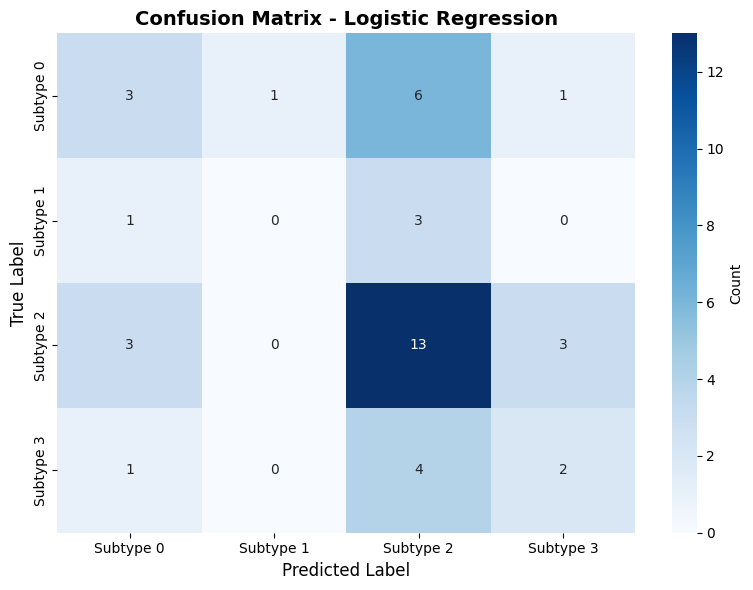

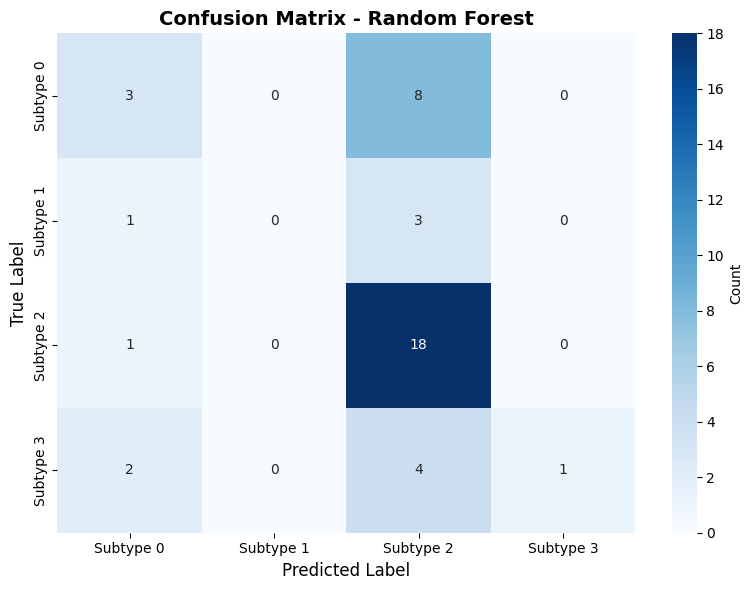

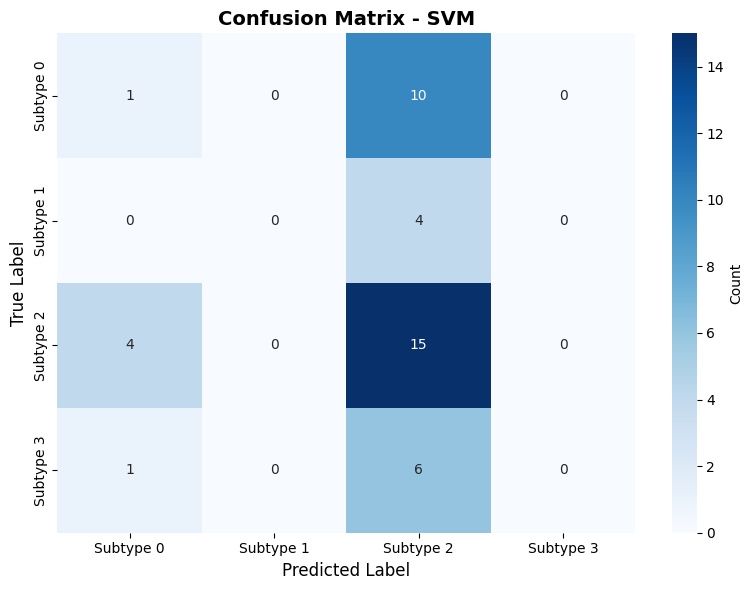

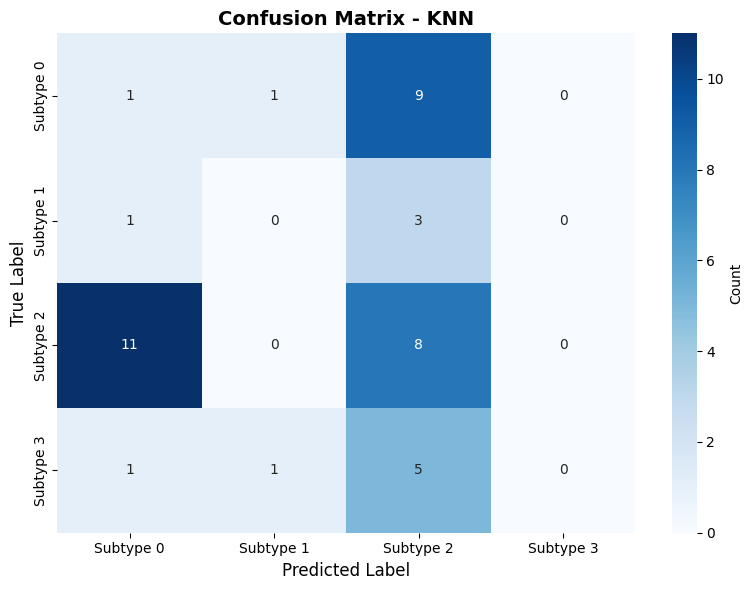

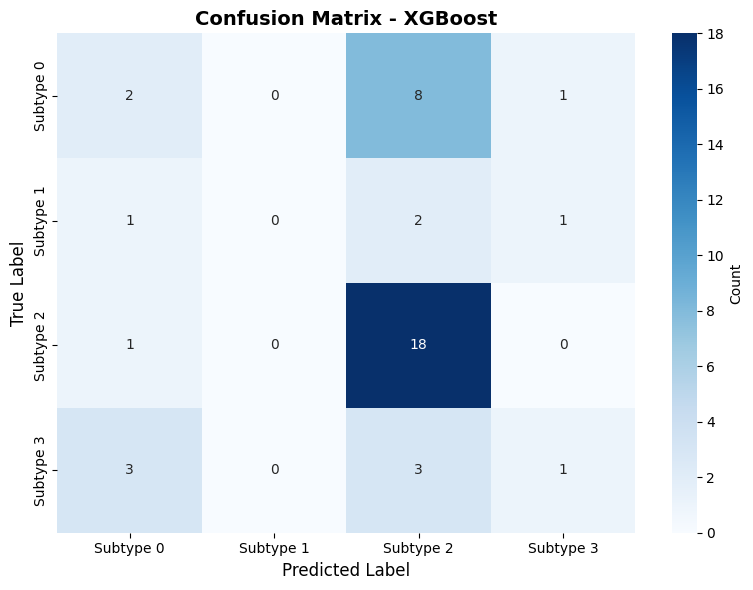

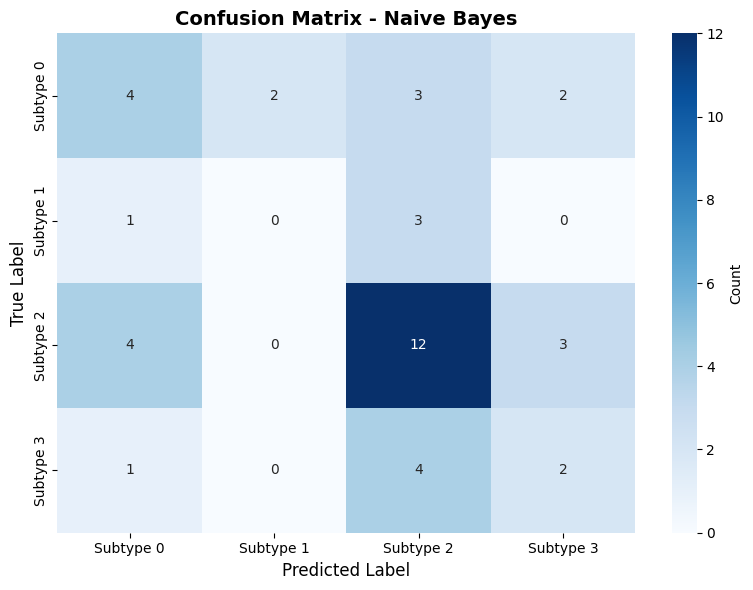


✅ Generated confusion matrices for 6 ML models


In [78]:
# Generate Confusion Matrices for All Traditional ML Models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(y_true, y_pred, model_name, class_names=None, figsize=(8, 6)):
    """Plot confusion matrix with better formatting"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    return cm

# Get unique class labels for consistent labeling
unique_classes = sorted(np.unique(y))
class_names = [f'Subtype {i}' for i in unique_classes]

print("🔍 CONFUSION MATRICES FOR TRADITIONAL ML MODELS")
print("=" * 60)

# Store all confusion matrices for comparison
ml_confusion_matrices = {}

# 1. Logistic Regression
cm_lr = plot_confusion_matrix(y_true_lr, preds_lr, 'Logistic Regression', class_names)
ml_confusion_matrices['Logistic Regression'] = cm_lr
plt.show()

# 2. Random Forest
cm_rf = plot_confusion_matrix(y_true_rf, preds_rf, 'Random Forest', class_names)
ml_confusion_matrices['Random Forest'] = cm_rf
plt.show()

# 3. SVM
cm_svm = plot_confusion_matrix(y_true_svm, preds_svm, 'SVM', class_names)
ml_confusion_matrices['SVM'] = cm_svm
plt.show()

# 4. KNN
cm_knn = plot_confusion_matrix(y_true_knn, preds_knn, 'KNN', class_names)
ml_confusion_matrices['KNN'] = cm_knn
plt.show()

# 5. XGBoost (if available)
try:
    cm_xgb = plot_confusion_matrix(y_true_xgb, preds_xgb, 'XGBoost', class_names)
    ml_confusion_matrices['XGBoost'] = cm_xgb
    plt.show()
except:
    print("XGBoost not available for confusion matrix")

# 6. Naive Bayes
cm_nb = plot_confusion_matrix(y_true_nb, preds_nb, 'Naive Bayes', class_names)
ml_confusion_matrices['Naive Bayes'] = cm_nb
plt.show()

print(f"\n✅ Generated confusion matrices for {len(ml_confusion_matrices)} ML models")


🧠 CONFUSION MATRICES FOR NEURAL NETWORK MODELS


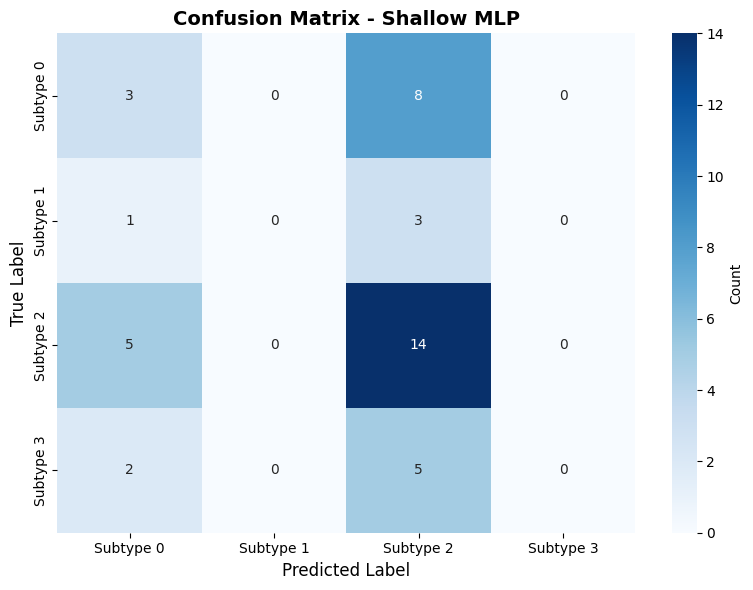

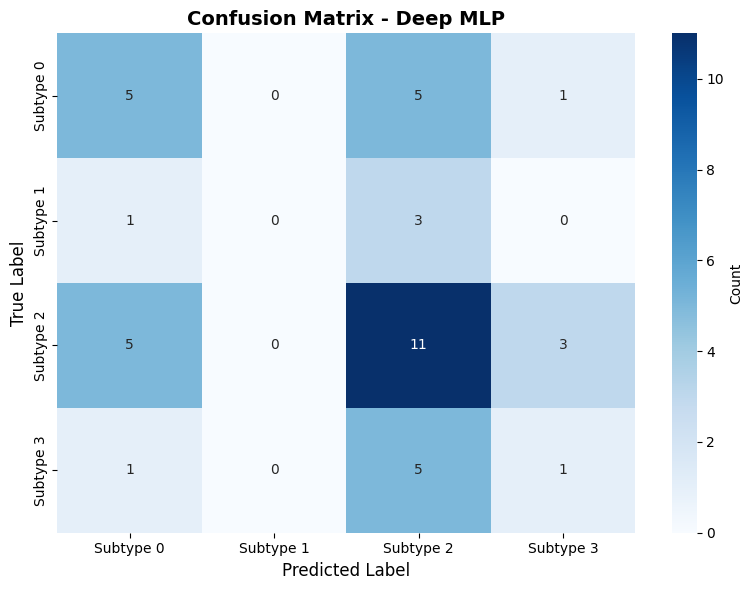

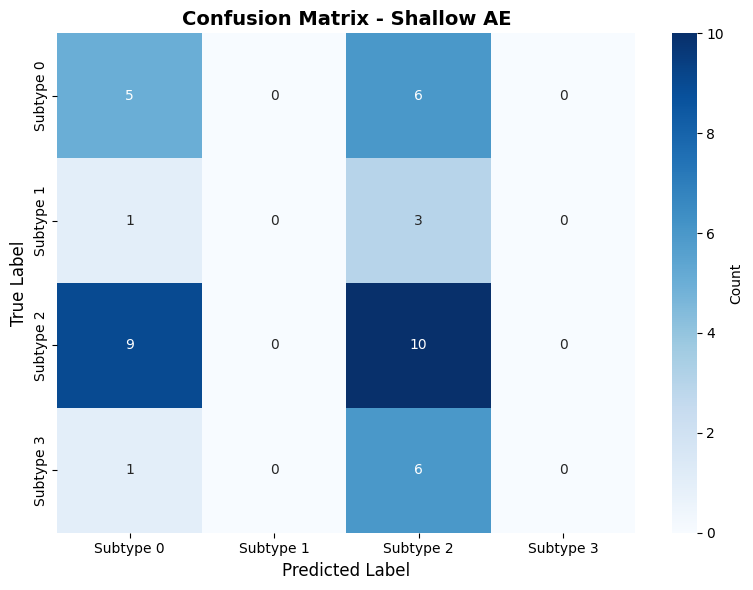

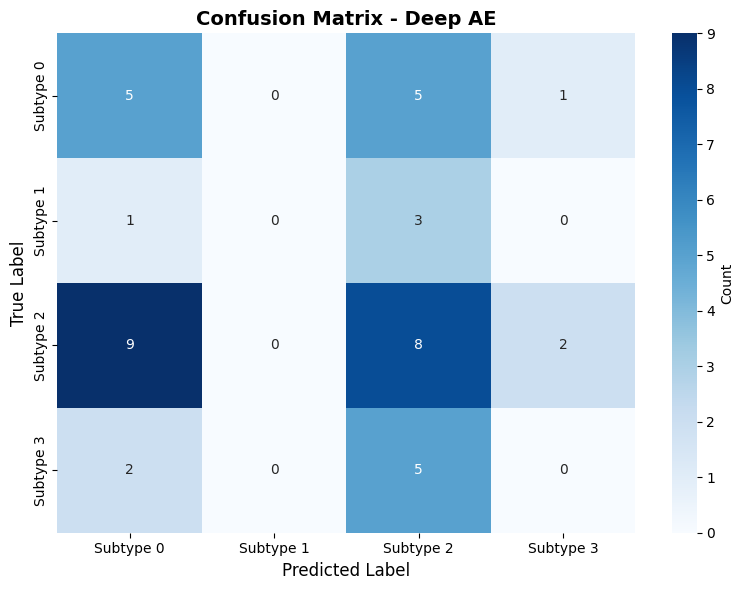


✅ Generated confusion matrices for 4 neural network models


In [79]:
# Generate Confusion Matrices for Neural Network Models
print("\n🧠 CONFUSION MATRICES FOR NEURAL NETWORK MODELS")
print("=" * 60)

# Store all NN confusion matrices for comparison
nn_confusion_matrices = {}

# 1. Shallow MLP
cm_shallow_mlp = plot_confusion_matrix(y_true_shallow, preds_shallow, 'Shallow MLP', class_names)
nn_confusion_matrices['Shallow MLP'] = cm_shallow_mlp
plt.show()

# 2. Deep MLP
cm_deep_mlp = plot_confusion_matrix(y_true_deep, preds_deep, 'Deep MLP', class_names)
nn_confusion_matrices['Deep MLP'] = cm_deep_mlp
plt.show()

# 3. Shallow AE
cm_shallow_ae = plot_confusion_matrix(y_true_ae, preds_shallow_ae, 'Shallow AE', class_names)
nn_confusion_matrices['Shallow AE'] = cm_shallow_ae
plt.show()

# 4. Deep AE
cm_deep_ae = plot_confusion_matrix(y_true_ae, preds_deep_ae, 'Deep AE', class_names)
nn_confusion_matrices['Deep AE'] = cm_deep_ae
plt.show()

print(f"\n✅ Generated confusion matrices for {len(nn_confusion_matrices)} neural network models")

In [81]:
# Detailed Classification Reports for All Models
print("\n📋 DETAILED CLASSIFICATION REPORTS")
print("=" * 80)

def print_classification_report_formatted(y_true, y_pred, model_name):
    """Print formatted classification report"""
    print(f"\n🔍 {model_name} - Detailed Classification Report:")
    print("-" * 60)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(report)
    
    # Additional metrics
    from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print("-" * 60)

# Classification reports for ML models
print("🤖 TRADITIONAL ML MODELS - CLASSIFICATION REPORTS")
print_classification_report_formatted(y_true_lr, preds_lr, "Logistic Regression")
print_classification_report_formatted(y_true_rf, preds_rf, "Random Forest")
print_classification_report_formatted(y_true_svm, preds_svm, "SVM")
print_classification_report_formatted(y_true_knn, preds_knn, "KNN")

try:
    print_classification_report_formatted(y_true_xgb, preds_xgb, "XGBoost")
except:
    print("XGBoost classification report not available")

print_classification_report_formatted(y_true_nb, preds_nb, "Naive Bayes")

# Classification reports for NN models
print("\n🧠 NEURAL NETWORK MODELS - CLASSIFICATION REPORTS")
print_classification_report_formatted(y_true_shallow, preds_shallow, "Shallow MLP")
print_classification_report_formatted(y_true_deep, preds_deep, "Deep MLP")
print_classification_report_formatted(y_true_ae, preds_shallow_ae, "Shallow AE")
print_classification_report_formatted(y_true_ae, preds_deep_ae, "Deep AE")


📋 DETAILED CLASSIFICATION REPORTS
🤖 TRADITIONAL ML MODELS - CLASSIFICATION REPORTS

🔍 Logistic Regression - Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

   Subtype 0     0.3750    0.2727    0.3158        11
   Subtype 1     0.0000    0.0000    0.0000         4
   Subtype 2     0.5000    0.6842    0.5778        19
   Subtype 3     0.3333    0.2857    0.3077         7

    accuracy                         0.4390        41
   macro avg     0.3021    0.3107    0.3003        41
weighted avg     0.3892    0.4390    0.4050        41

Balanced Accuracy: 0.3107
Cohen's Kappa: 0.1045
------------------------------------------------------------

🔍 Random Forest - Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

   Subtype 0     0.4286    0.2727    0.3333        11
   Subtype 1     0.0000    0.0000


📊 PER-CLASS PERFORMANCE ANALYSIS


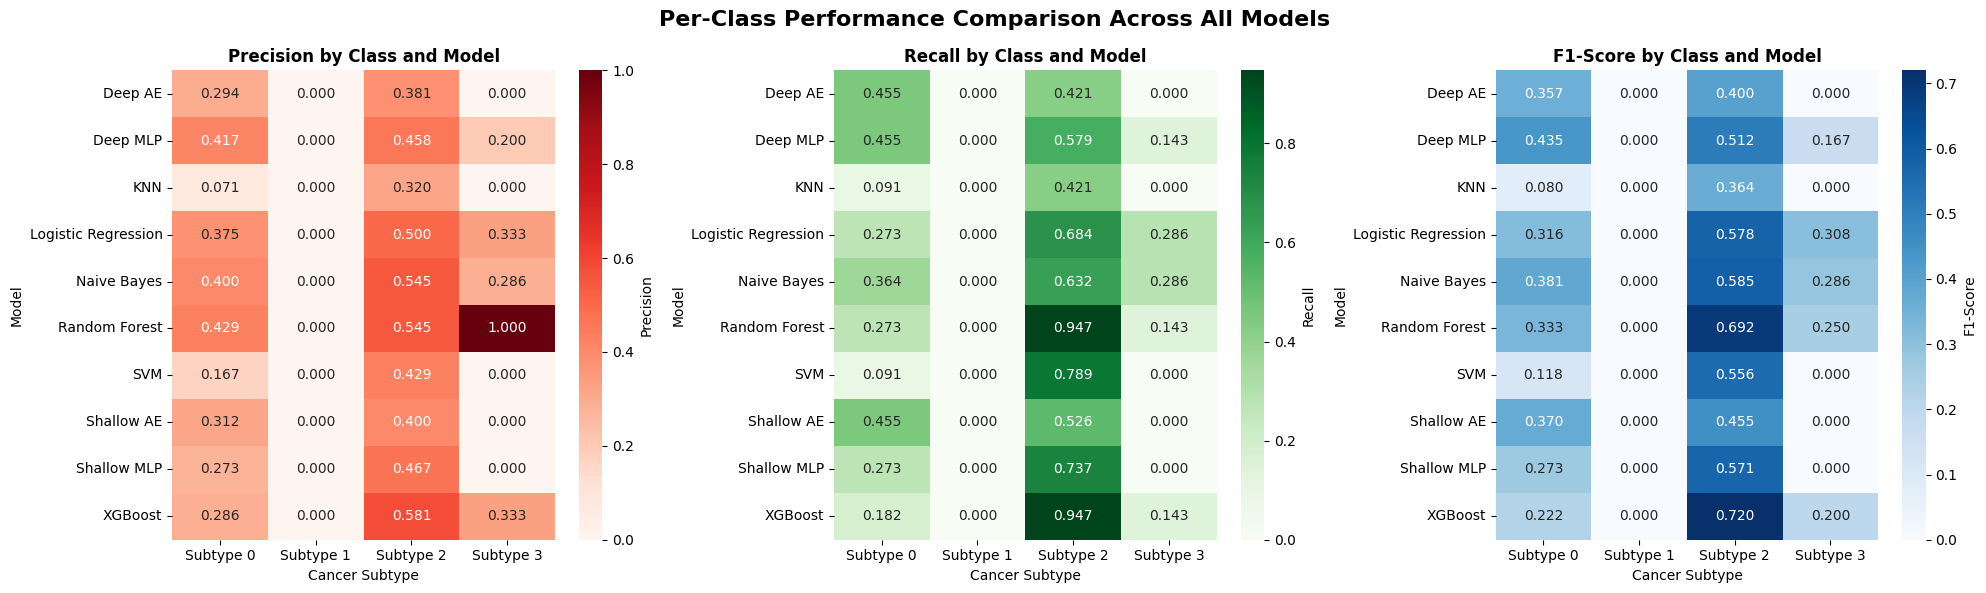


📈 Per-Class Performance Summary:
------------------------------------------------------------

Subtype 0:
  Best Precision: Random Forest (0.429)
  Best Recall: Deep MLP (0.455)
  Best F1-Score: Deep MLP (0.435)
  Support: 11 samples

Subtype 1:
  Best Precision: Logistic Regression (0.000)
  Best Recall: Logistic Regression (0.000)
  Best F1-Score: Logistic Regression (0.000)
  Support: 4 samples

Subtype 2:
  Best Precision: XGBoost (0.581)
  Best Recall: Random Forest (0.947)
  Best F1-Score: XGBoost (0.720)
  Support: 19 samples

Subtype 3:
  Best Precision: Random Forest (1.000)
  Best Recall: Logistic Regression (0.286)
  Best F1-Score: Logistic Regression (0.308)
  Support: 7 samples

✅ Per-class analysis completed for 10 models and 4 classes


In [82]:
# Per-Class Performance Analysis Across All Models
print("\n📊 PER-CLASS PERFORMANCE ANALYSIS")
print("=" * 80)

# Function to extract per-class metrics
def extract_per_class_metrics(y_true, y_pred, model_name):
    """Extract per-class precision, recall, and F1-score"""
    from sklearn.metrics import precision_recall_fscore_support
    
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    
    metrics = []
    for i, class_name in enumerate(class_names):
        metrics.append({
            'Model': model_name,
            'Class': class_name,
            'Precision': precision[i],
            'Recall': recall[i],
            'F1-Score': f1[i],
            'Support': support[i]
        })
    
    return metrics

# Collect per-class metrics for all models
all_per_class_metrics = []

# ML Models
all_per_class_metrics.extend(extract_per_class_metrics(y_true_lr, preds_lr, "Logistic Regression"))
all_per_class_metrics.extend(extract_per_class_metrics(y_true_rf, preds_rf, "Random Forest"))
all_per_class_metrics.extend(extract_per_class_metrics(y_true_svm, preds_svm, "SVM"))
all_per_class_metrics.extend(extract_per_class_metrics(y_true_knn, preds_knn, "KNN"))

try:
    all_per_class_metrics.extend(extract_per_class_metrics(y_true_xgb, preds_xgb, "XGBoost"))
except:
    pass

all_per_class_metrics.extend(extract_per_class_metrics(y_true_nb, preds_nb, "Naive Bayes"))

# NN Models
all_per_class_metrics.extend(extract_per_class_metrics(y_true_shallow, preds_shallow, "Shallow MLP"))
all_per_class_metrics.extend(extract_per_class_metrics(y_true_deep, preds_deep, "Deep MLP"))
all_per_class_metrics.extend(extract_per_class_metrics(y_true_ae, preds_shallow_ae, "Shallow AE"))
all_per_class_metrics.extend(extract_per_class_metrics(y_true_ae, preds_deep_ae, "Deep AE"))

# Convert to DataFrame
per_class_df = pd.DataFrame(all_per_class_metrics)

# Create visualization for per-class performance
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Per-Class Performance Comparison Across All Models', fontsize=16, fontweight='bold')

# Precision comparison
precision_pivot = per_class_df.pivot(index='Model', columns='Class', values='Precision')
sns.heatmap(precision_pivot, annot=True, fmt='.3f', cmap='Reds', ax=axes[0], cbar_kws={'label': 'Precision'})
axes[0].set_title('Precision by Class and Model', fontweight='bold')
axes[0].set_xlabel('Cancer Subtype')
axes[0].set_ylabel('Model')

# Recall comparison
recall_pivot = per_class_df.pivot(index='Model', columns='Class', values='Recall')
sns.heatmap(recall_pivot, annot=True, fmt='.3f', cmap='Greens', ax=axes[1], cbar_kws={'label': 'Recall'})
axes[1].set_title('Recall by Class and Model', fontweight='bold')
axes[1].set_xlabel('Cancer Subtype')
axes[1].set_ylabel('Model')

# F1-Score comparison
f1_pivot = per_class_df.pivot(index='Model', columns='Class', values='F1-Score')
sns.heatmap(f1_pivot, annot=True, fmt='.3f', cmap='Blues', ax=axes[2], cbar_kws={'label': 'F1-Score'})
axes[2].set_title('F1-Score by Class and Model', fontweight='bold')
axes[2].set_xlabel('Cancer Subtype')
axes[2].set_ylabel('Model')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📈 Per-Class Performance Summary:")
print("-" * 60)
for class_name in class_names:
    class_data = per_class_df[per_class_df['Class'] == class_name]
    best_precision_model = class_data.loc[class_data['Precision'].idxmax(), 'Model']
    best_recall_model = class_data.loc[class_data['Recall'].idxmax(), 'Model']
    best_f1_model = class_data.loc[class_data['F1-Score'].idxmax(), 'Model']
    
    print(f"\n{class_name}:")
    print(f"  Best Precision: {best_precision_model} ({class_data['Precision'].max():.3f})")
    print(f"  Best Recall: {best_recall_model} ({class_data['Recall'].max():.3f})")
    print(f"  Best F1-Score: {best_f1_model} ({class_data['F1-Score'].max():.3f})")
    print(f"  Support: {class_data['Support'].iloc[0]} samples")

print(f"\n✅ Per-class analysis completed for {len(per_class_df['Model'].unique())} models and {len(class_names)} classes")